<style type='text/css'> body {background-image: url('sfondo_slides.png') !important;} </style>
# LAB4
         Project done by Michela Pirozzi MAT:732531 and Sara Ferioli MAT:733105

## Goal
* Given the features in the dataset, what is the best combination to have a new contract? Was the feature combination the same even before covid?

* Predict number of contracts. Is the number of contracts predicted for the future in 2019 the same or similar to the actual data given the occurrence of COVID? 

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree 
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Functions

In [2]:
# Method that allow to extract only specific (time) years
# syntax:
# df: dataframe
# time: regex. es: r'20(18|19|20|21)' or r'2020'
def set_years(df,time):
    df.replace(r'..(/|-)..(/|-)','',regex=True, inplace = True)
    df = df[df["DATA"].str.match(time)==True]
    return df

In [3]:
# Method that allow to extract only specific (time) mouths, modify the data order: yyyy/mm
# syntax:
# df: dataframe
# time: regex. es: r'20(18|19|20|21)' or r'2020'
def set_mouths(df,time):
    df.DATA.replace(r'..(/|-)(..)(/|-)(....)' , r'\4\3\2', regex=True,inplace=True,)
    df = df[df["DATA"].str.match(time)==True]
    return df

In [4]:
# Method that creates an animated histogram
# syntax:
# df: dataframe
# column: column on which you want to group
# time: column on which you want to animate
def time_for_column(df, column, time):
    df_merge_col = df.groupby([column, time]).size().sort_values(ascending=False).reset_index(name='count')
    tot = px.bar(df_merge_col, x=column, y='count', animation_frame=time,
                 animation_group=column, color=column)
    tot.update_layout(title='')
    tot.update_xaxes(categoryorder='total ascending')
    tot.show()

In [5]:
# Method for creating a geographic map.
# syntaxt:
# df: dataframe
# column: column on which you want to group
def map_fig(df,column):
    df_merge_col = df.groupby([column, "latitudine","longitudine"]).size().reset_index(name='count')
    df_merge_col['count']=df_merge_col['count']/100
    df_merge_col['count']=list(map(int, df_merge_col['count']))
    fig = px.scatter_mapbox(df_merge_col, lat="latitudine", lon="longitudine", color=column,
                      size="count", zoom=6)
    fig.update_layout(mapbox_style="open-street-map")
    fig.show()

In [6]:
# Method for creating a line graph with two lines.
# syntaxt:
# df1: dataframe
# df2: dataframe
# column: elements of x-axis
# name1: name of the first line
# name2: name of the second line
def line_fig(df1,df2,column,name1,name2):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df1[column], y=df1["count"],
                        mode='lines',
                        name=name1))
    fig.add_trace(go.Scatter(x=df2[column], y=df2["count"],
                        mode='lines',
                        name=name2))
    fig.update_xaxes(categoryorder='category ascending')

    # lockdown period
    fig.add_vline(x='2020/03', line_width=3, line_dash="dash", line_color="green")
    fig.add_vline(x='2020/09', line_width=3, line_dash="dash", line_color="green")

    fig.show()

In [7]:
# Function that return the maximum and minimum value and the their indexes (in this case the type of sector)
# syntax:
# data: dataframe on which retrieve values
def find_maxmin(data):
    grouped = data.groupby(["SETTOREECONOMICODETTAGLIO", "DATA"]).size().sort_values(ascending=False)
    max_val = grouped.max()
    idmax = grouped.idxmax()
    min_val= grouped.min()
    idmin = grouped.idxmin()

    return max_val, idmax[0], min_val, idmin[0]

In [8]:
# Method that allow to load ateco csv and prepare the data for the join
def addingAteco():
    df_ateco = pd.read_csv("ateco.csv")
    df_ateco.Descrizione_ateco.replace(r'^.* - ' , '',regex=True, inplace = True,)
    df_ateco = df_ateco.drop("_id",axis=1)
    df_ateco.rename(columns = {"Descrizione_ateco":"SETTOREECONOMICODETTAGLIO"}, inplace = True)
    df_ateco['SETTOREECONOMICODETTAGLIO'] = df_ateco['SETTOREECONOMICODETTAGLIO'].str.upper()
    df_ateco.drop_duplicates(subset="SETTOREECONOMICODETTAGLIO",keep="first",inplace=True)
    return df_ateco

In [9]:
# Commento
def find_best_max_depth(X_train,y_train,X_test,y_test):
    # Find the max depth neccessary for the Decision tree
    max_depth = []
    acc_gini = []
    acc_entropy = []
    for i in range(1,30):
         dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
         dtree.fit(X_train, y_train)
         pred = dtree.predict(X_test)
         acc_gini.append(accuracy_score(y_test, pred))
         ####
         dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
         dtree.fit(X_train, y_train)
         pred = dtree.predict(X_test)
         acc_entropy.append(accuracy_score(y_test, pred))
         ####
         max_depth.append(i)
    d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
     'acc_entropy':pd.Series(acc_entropy),
     'max_depth':pd.Series(max_depth)})
    # visualizing changes in parameters
    plt.plot('max_depth','acc_gini', data=d, label='gini')
    plt.plot('max_depth','acc_entropy', data=d, label='entropy')
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()

In [10]:
# Method that allow to scaled the features
# syntax:
# data_train: train dataframe
# data_test: test dataframe
def scaleFeaturesDF(data_train, data_test):

    transf = preprocessing.MinMaxScaler().fit(data_train)
    data_train = transf.transform(data_train)
    data_train = pd.DataFrame(data_train)
    data_test = transf.transform(data_test)
    data_test = pd.DataFrame(data_test)
    
    
    return data_train, data_test

In [11]:
# Search p and q values
def arima_aic(bal2):
    arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

    i=0
    # Loop over p values from 0-5
    for p in range(4):
        # Loop over q values from 0-5
        for q in range(4):
        
            try:
                # creating and fitting ARIMA(p,1,q) model
                model = ARIMA(bal2['count'].astype(float), order=(p,1,q))
                results = model.fit()
            
                # Printing order, AIC and BIC
                #print(p, q, results.aic, results.bic)
                arima_df.loc[i,"p"] = p
                arima_df.loc[i,"q"] = q
                arima_df.loc[i,"aic"] = results.aic
                arima_df.loc[i,"bic"] = results.bic
                i = i+1
            except:
                #print(p, q, None, None)
                i = i+1
    
    arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
    arima_df.sort_values(by="aic", ascending=False, inplace=True)
    return arima_df

## Import data

In [12]:
# Load dataset
attivati = pd.read_csv("Rapporti_di_lavoro_attivati.csv")
attivati.head()

DATA GENERE  ETA                          SETTOREECONOMICODETTAGLIO  \
0  09/05/2020      F   60  Attività di famiglie e convivenze come datori ...   
1  12/07/2019      M   43  Gestioni di funicolari, ski-lift e seggiovie s...   
2  05/06/2013      F   20  Fabbricazione di altre apparecchiature elettri...   
3  12/03/2010      F   28                                           Alberghi   
4  06/04/2021      F   49                                 Rifugi di montagna   

                                        TITOLOSTUDIO  \
0                            NESSUN TITOLO DI STUDIO   
1                                      LICENZA MEDIA   
2                                      LICENZA MEDIA   
3  DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...   
4                                      LICENZA MEDIA   

                                           CONTRATTO MODALITALAVORO  \
0                                   LAVORO DOMESTICO    TEMPO PIENO   
1                         LAVORO A TEMPO DETERMINATO    TEMPO PIENO   
2  APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...    TEMPO PIENO   
3           LAVORO INTERMITTENTE A TEMPO DETERMINATO   NON DEFINITO   
4                               LAVORO INTERMITTENTE   NON DEFINITO   

  PROVINCIAIMPRESA ITALIANO  
0          BERGAMO  UCRAINA  
1          BERGAMO   ITALIA  
2          BERGAMO   ITALIA  
3          BERGAMO   ITALIA  
4          BERGAMO   ITALIA

## Data analysis

In [ ]:
# Extract only the columns that are needed
dati = attivati[["DATA","CONTRATTO"]]
# I only consider the years of the covid and the previous ones
dati=set_years(dati,r'20(18|19|20|21)')
# I consider only the most frequent contracts
df_merge_col = dati.groupby(["CONTRATTO"]).size().sort_values(ascending=False).reset_index(name='count')
df_merge_col = df_merge_col[df_merge_col["count"]>10000]
dati=dati[dati["CONTRATTO"].isin(df_merge_col["CONTRATTO"])]

### Contracts during the years

In [ ]:
# Show the graph
time_for_column(dati,"CONTRATTO","DATA")

### Which sectors are most affected by covid?

In [ ]:
# Extract from the dataset, only the columns of interest
dati = attivati[["DATA", "SETTOREECONOMICODETTAGLIO"]]
# I only consider the years of the covid and the previous ones
dati=set_years(dati,r'20(18|19|20|21)')
''' There are some null rows, and we decided to delete them because they are few compared to the dataset and do not compromise 
the result and also deducing their value would cost too much in comparison with the quality of information we could obtain. '''
dati = dati.dropna(axis=0)
# Consider only economic sectors with a certain frequency within the dataset 
df_merge_col = dati.groupby(["SETTOREECONOMICODETTAGLIO"]).size().sort_values(ascending=False).reset_index(name='count')
df_merge_col = df_merge_col[df_merge_col["count"]>40000]
dati1=dati[dati["SETTOREECONOMICODETTAGLIO"].isin(df_merge_col["SETTOREECONOMICODETTAGLIO"])]
df_merge_col = dati1.groupby(["SETTOREECONOMICODETTAGLIO", "DATA"]).size().sort_values(ascending=False).reset_index(name='count')

In [ ]:
# Show the graph
px.bar(df_merge_col, 'SETTOREECONOMICODETTAGLIO', 'count', 
       color='SETTOREECONOMICODETTAGLIO', animation_frame='DATA',
       category_orders={'DATA':['2018', '2019', '2020', '2021']}, title='', range_y=[0, 60000])

#### Results
We can see that housework ('Attività di famiglie e convivenze come datori di lavoro per personale domestico') during the covid has increased. Instead, hotel ('Alberghi') and catering ('Ristorazione con somministrazione') sector have decreased.

### Geographical representation

In [ ]:
# Extract only the columns that are needed
dati = attivati[['DATA', 'CONTRATTO', 'PROVINCIAIMPRESA']]
# I only consider the years before and after the covid
dati=set_years(dati,r'20(19|21)') # lo teniamo o no?
# I consider only the most frequent contracts
df_merge_col = dati.groupby(["CONTRATTO"]).size().sort_values(ascending=False).reset_index(name='count')
df_merge_col = df_merge_col[df_merge_col["count"]>10000]
dati=dati[dati["CONTRATTO"].isin(df_merge_col["CONTRATTO"])]


# latitude mapping
dati.loc[dati['PROVINCIAIMPRESA']=='BERGAMO','latitudine']=45.6982642
dati.loc[dati['PROVINCIAIMPRESA']=='LECCO','latitudine']=45.8566
dati.loc[dati['PROVINCIAIMPRESA']=='BRESCIA','latitudine']=45.5257
dati.loc[dati['PROVINCIAIMPRESA']=='COMO','latitudine']=45.8109
dati.loc[dati['PROVINCIAIMPRESA']=='LODI','latitudine']=45.3145
dati.loc[dati['PROVINCIAIMPRESA']=='MANTOVA','latitudine']=45.153
dati.loc[dati['PROVINCIAIMPRESA']=='CREMONA','latitudine']=45.1371
dati.loc[dati['PROVINCIAIMPRESA']=='PAVIA','latitudine']=45.1854
dati.loc[dati['PROVINCIAIMPRESA']=='MILANO','latitudine']=45.4654219
dati.loc[dati['PROVINCIAIMPRESA']=='VARESE','latitudine']=45.83
dati.loc[dati['PROVINCIAIMPRESA']=='SONDRIO','latitudine']=46.1699
dati.loc[dati['PROVINCIAIMPRESA']=='MONZA E BRIANZA','latitudine']=45.5834


# longitude mapping
dati.loc[dati['PROVINCIAIMPRESA']=='BERGAMO','longitudine']=9.6772698
dati.loc[dati['PROVINCIAIMPRESA']=='LECCO','longitudine']=9.4039
dati.loc[dati['PROVINCIAIMPRESA']=='BRESCIA','longitudine']=10.2283
dati.loc[dati['PROVINCIAIMPRESA']=='COMO','longitudine']=9.0885
dati.loc[dati['PROVINCIAIMPRESA']=='LODI','longitudine']=9.5039
dati.loc[dati['PROVINCIAIMPRESA']=='MANTOVA','longitudine']=10.7748
dati.loc[dati['PROVINCIAIMPRESA']=='CREMONA','longitudine']=10.029
dati.loc[dati['PROVINCIAIMPRESA']=='PAVIA','longitudine']=9.1625
dati.loc[dati['PROVINCIAIMPRESA']=='MILANO','longitudine']=9.1859243
dati.loc[dati['PROVINCIAIMPRESA']=='VARESE','longitudine']=8.823
dati.loc[dati['PROVINCIAIMPRESA']=='SONDRIO','longitudine']=9.8702
dati.loc[dati['PROVINCIAIMPRESA']=='MONZA E BRIANZA','longitudine']=9.2759

In [ ]:
# Show the graph
map_fig(dati,"CONTRATTO")

### How covid has affected the active contract according to age and gender?

In [ ]:
# Extract only the columns that are needed
dati=attivati[["ETA","GENERE","DATA"]]

# I only consider the years before and after the covid
datibefore=set_years(dati,r'20(18|19)')
datiafter=set_years(dati,r'20(20|21)')

# Gender selection
femalebefore=datibefore[datibefore["GENERE"]=="F"]
malebefore=datibefore[datibefore["GENERE"]=="M"]
femaleafter=datiafter[datiafter["GENERE"]=="F"]
maleafter=datiafter[datiafter["GENERE"]=="M"]

# Create new dataframe depending on age and gender
femalebefore_merge_col = femalebefore.groupby(["ETA"]).size().reset_index(name='count')
femalebefore_merge_col=femalebefore_merge_col[["ETA","count"]]
malebefore_merge_col = malebefore.groupby(["ETA"]).size().reset_index(name='count')
malebefore_merge_col=malebefore_merge_col[["ETA","count"]]

femaleafter_merge_col = femaleafter.groupby(["ETA"]).size().reset_index(name='count')
femaleafter_merge_col=femaleafter_merge_col[["ETA","count"]]
maleafter_merge_col = maleafter.groupby(["ETA"]).size().reset_index(name='count')
maleafter_merge_col=maleafter_merge_col[["ETA","count"]]

In [ ]:
# Show the graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=femalebefore_merge_col["ETA"], y=femalebefore_merge_col["count"],
                    mode='lines',
                    name='female before'))
fig.add_trace(go.Scatter(x=malebefore_merge_col["ETA"], y=malebefore_merge_col["count"],
                    mode='lines',
                    name='male before'))
fig.add_trace(go.Scatter(x=femaleafter_merge_col["ETA"], y=femaleafter_merge_col["count"],
                    mode='lines',
                    name='female after'))
fig.add_trace(go.Scatter(x=maleafter_merge_col["ETA"], y=maleafter_merge_col["count"],
                    mode='lines',
                    name='male after'))

In [ ]:
fig.show()

### Comparison between extended and terminated contract during covid.

In [ ]:
# Load the dataset
prorogati = pd.read_csv("Rapporti_di_lavoro_prorogati.csv")
cessati = pd.read_csv("Rapporti_di_lavoro_cessati.csv")

# Extract only the columns that are needed
selectedprorogati = prorogati[["DATA", "PROVINCIAIMPRESA"]]
selectedcessati = cessati[["DATA", "PROVINCIAIMPRESA"]]

# I only consider the years of the covid
selectedprorogati=set_years(selectedprorogati,r'20(20|21)')
selectedprorogati['type']="prorogati"

# I only consider the years of the covid
selectedcessati=set_years(selectedcessati,r'20(20|21)')
selectedcessati['type']="cessati"

# Union of the two datasets
union=pd.concat([selectedprorogati,selectedcessati],axis = 0,ignore_index = True)

In [ ]:
# lockdown period in green
prorogati=set_mouths(prorogati,r'20(18|19|20|21)')
cessati=set_mouths(cessati,r'20(18|19|20|21)')
prorogati_merge_col = prorogati.groupby(["DATA"]).size().sort_values(ascending=False).reset_index(name='count')
prorogati_merge_col=prorogati_merge_col.sort_values(by=['DATA']).reset_index()
cessati_merge_col = cessati.groupby(["DATA"]).size().sort_values(ascending=False).reset_index(name='count')
cessati_merge_col=cessati_merge_col.sort_values(by=['DATA']).reset_index()

In [ ]:
# Show the graph
line_fig(prorogati_merge_col,cessati_merge_col,"DATA","prorogati","cessati")

### Which sectors have more or less active, extended or terminated constract, during covid?

In [ ]:
# Extract only the columns that are needed
attivatisplit = attivati[["DATA", "SETTOREECONOMICODETTAGLIO", "ETA"]]

''' There are some null rows, and we decided to delete them because they are few compared to the dataset and do not compromise 
the result and also deducing their value would cost too much in comparison with the quality of information we could obtain. '''
attivatisplit = attivatisplit.dropna(axis=0)

# Select only the yers of interest
attivati20=set_years(attivatisplit,r'2020')

# Select only the yers of interest
attivati21=set_years(attivatisplit,r'2021')

# Min and Max values for the activated contracts in 2020
max_a20, idmax_a20, min_a20, idmin_a20 = find_maxmin(attivati20)

# Min and Max values for the activated contracts in 2021
max_a21, idmax_a21, min_a21, idmin_a21 = find_maxmin(attivati21)

In [ ]:
print(f'The sector with the max number of activated contracts in 2020 is "{idmax_a20}" with {max_a20} contracts')
print(f'The sector with the min number of activated contracts in 2020 is "{idmin_a20}" with {min_a20} contracts')

print(f'The sector with the max number of activated contracts in 2021 is "{idmax_a21}" with {max_a21} contracts')
print(f'The sector with the min number of activated contracts in 2021 is "{idmin_a21}" with {min_a21} contracts')

The sector with the max number of activated contracts in 2020 is "Attività di famiglie e convivenze come datori di lavoro per personale domestico" with 49228 contracts
The sector with the min number of activated contracts in 2020 is "Trasporto mediante condotte di liquidi" with 1 contracts
The sector with the max number of activated contracts in 2021 is "Attività di produzione cinematografica, di video e di programmi televisivi" with 33020 contracts
The sector with the min number of activated contracts in 2021 is "Trasporto mediante condotte di liquidi" with 1 contracts


## Transformations

### Adding Ateco

In [13]:
ateco = addingAteco()

# Transformations of the strings in upper case, to make join
attivati['SETTOREECONOMICODETTAGLIO'] = attivati['SETTOREECONOMICODETTAGLIO'].str.upper()

# Retrieve only the year from the date
attivati['DATA'] = pd.to_datetime(attivati['DATA'], format="%d/%m/%Y")
attivati['mese-anno'] = attivati['DATA'].apply(lambda x: x.strftime('%Y-%m'))
attivati ['ANNO'] = attivati.DATA.dt.year
attivati = attivati.drop(labels='DATA', axis=1)

# Join between the two DataFrames
join = pd.merge(attivati, ateco, on =['SETTOREECONOMICODETTAGLIO'], how='inner')

# Obtain only the first two digits of the 'codice ateco' to understand the macro category
join.Codice_ateco.replace(r'^(..)\..*' , r'\1',regex=True, inplace = True,)

# Extract macro category
join = pd.merge(join, ateco, on='Codice_ateco', how='inner')

# Delete the sub category
join = join.drop(labels='SETTOREECONOMICODETTAGLIO_x', axis=1)

# Transformations of the strings in upper case, to make a match, without problem
join['CONTRATTO']=join['CONTRATTO'].str.upper()

In [14]:
join.head()

GENERE  ETA             TITOLOSTUDIO                             CONTRATTO  \
0      F   60  NESSUN TITOLO DI STUDIO                      LAVORO DOMESTICO   
1      F   33  NESSUN TITOLO DI STUDIO  LAVORO DOMESTICO A TEMPO DETERMINATO   
2      F   45  NESSUN TITOLO DI STUDIO                      LAVORO DOMESTICO   
3      F   61  NESSUN TITOLO DI STUDIO                      LAVORO DOMESTICO   
4      F   20  NESSUN TITOLO DI STUDIO                      LAVORO DOMESTICO   

               MODALITALAVORO PROVINCIAIMPRESA  ITALIANO mese-anno  ANNO  \
0                 TEMPO PIENO          BERGAMO   UCRAINA   2020-05  2020   
1  TEMPO PARZIALE ORIZZONTALE          BERGAMO  HONDURAS   2012-07  2012   
2                 TEMPO PIENO          BERGAMO    ITALIA   2019-04  2019   
3                 TEMPO PIENO            LECCO   UCRAINA   2014-09  2014   
4  TEMPO PARZIALE ORIZZONTALE            LECCO    ITALIA   2014-05  2014   

  Codice_ateco                        SETTOREECONOMICODETTAGLIO_y  
0           97  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  
1           97  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  
2           97  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  
3           97  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  
4           97  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...

### Other transformations

In [15]:
# Set generic category for the contracts 
join.loc[join['CONTRATTO'].str.match(r'.*INDETERMINATO.*') == True,"CONTRATTO"]="INDETERMINATO"
join.loc[join['CONTRATTO'].str.match(r'.*INDETERMINATO.*') == False,"CONTRATTO"]="NON INDETERMINATO"

indeterminato=join.copy()

# Commento
africa=pd.DataFrame(["SENEGAL ","NIGERIA","MAROCCO","EGITTO","GUINEA","GHANA","Mauritius","ALGERIA","ETIOPIA","TUNISIA","COSTA D’AVORIO","CAMERUN","GUINEA EQUATORIALE","BENIN","MAURITANIA","ARGENTINA","TOGO","UGANDA","CONGO","NEPAL","ERITREA","Congo, Rep.Democratica","SIERRA LEONE","SOMALIA","GAMBIA","NIGER","KENYA","LIBIA","SEYCHELLES","SUD AFRICA","CAPO VERDE","BURUNDI","TANZANIA","GABON","ZIMBABWE","SUD SUDAN","GUINEA BISSAU","LIBERIA","ZAMBIA","ANGOLA","MADAGASCAR","SUDAN","RUANDA","Centrafricana, Repubblica","CIAD","MOZAMBICO","Sao Tomè e Principe","SWAZILAND","GUYANA","NAMIBIA"])
africa['merge']='AFRICA'
sudame=pd.DataFrame(["BOLIVIA ","ECUADOR ","PERU","COLOMBIA","BRASILE","VENEZUELA","PARAGUAY","CILE","MALI","URUGUAY","TRINIDAD E TOBAGO","SAINT LUCIA"])
sudame['merge']='SUD AMERICA'
centame=pd.DataFrame(["EL SALVADOR","Dominicana, Repubblica","CUBA","DOMINICA","BAHAMAS","HONDURAS","GUATEMALA","PANAMA","NICARAGUA","HAITI","BELIZE","ANTIGUA E BARBUDA","COSTA RICA","Saint Vincent e Grenadin"])
centame['merge']='CENTRO AMERICA'
asia=pd.DataFrame(["FILIPPINE","BANGLADESH","GEORGIA","PAKISTAN","INDIA","BURKINA FASO","KAZAKHSTAN","SIRIA","THAILANDIA","KIRGHIZISTAN","INDONESIA","AFGHANISTAN","AZERBAIGIAN","UZBEKISTAN","CAMBOGIA","MYANMAR","TAGIKISTAN","VIETNAM","ARMENIA","Corea, Repubblica Popolare","TUVALU","MONGOLIA","LAOS","MALAYSIA","TURKMENISTAN","VANUATU","PALAU","SINGAPORE","Corea, Repubblica","BHUTAN","Timor Orientale","TONGA","KIRIBATI","MALDIVE","BRUNEI","PAPUA NUOVA GUINEA","Micronesia, Stati Federati","NAURU","FIGI"])
asia['merge']='ASIA'
medioor=pd.DataFrame(["LIBANO","IRAN","ISRAELE","TURCHIA","YEMEN","BAHREIN","GIORDANIA","QATAR","IRAQ","Territori Autonomia Palestinese","ARABIA SAUDITA","OMAN","KUWAIT","EMIRATI ARABI UNITI","TERRITORI PALESTINESI"])
medioor['merge']='MEDIO ORIENTE'
singoli=pd.DataFrame(["TAIWAN" ,"Cinese, Repubblica Popolare","ROMANIA","Moldova","UCRAINA","SRI LANKA","APOLIDE","ITALIA","ALBANIA","RUSSA, Federazione","POLONIA","BOSNIA-ERZEGOVINA","UNGHERIA","GIAPPONE","MACEDONIA","ex REP. JUGOSLAVIA","CROAZIA","BULGARIA","SPAGNA","BIELORUSSIA","SERBIA E MONTENEGRO","FRANCIA","MONTENEGRO","LETTONIA","REGNO UNITO","AUSTRALIA","KOSOVO","LITUANIA","GERMANIA","ESTONIA","IRLANDA","MESSICO","PORTOGALLO","Marshall, Isole","DANIMARCA","GIAMAICA","STATI UNITI D’AMERICA","PAESI BASSI","CECA, Repubblica","BELGIO","SVIZZERA","SLOVENIA","CANADA","NORVEGIA","SLOVACCHIA","GRECIA","CIPRO","FINLANDIA","SVEZIA","MONACO","ANDORRA","MALTA","AUSTRIA","LUSSEMBURGO","ISLANDA","NUOVA ZELANDA","SAN MARINO"])
singoli=pd.concat([singoli,singoli], axis=1)
singoli.columns = [0,'merge']
naz=pd.concat([africa,sudame,centame,asia,medioor,singoli], ignore_index=True)
naz.columns = ['ITALIANO','merge']

# Commento
join =pd.merge(indeterminato, naz,on=['ITALIANO'],how='inner')

# Commento
join = join.drop(columns=["ITALIANO"])

# Commento
join.rename(columns={'merge':'ITALIANO'}, inplace=True)
indeterminato=join.copy()

In [16]:
indeterminato.head()

GENERE  ETA             TITOLOSTUDIO          CONTRATTO  \
0      F   60  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
1      F   61  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
2      F   29  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
3      F   48  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
4      F   54  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   

               MODALITALAVORO PROVINCIAIMPRESA mese-anno  ANNO Codice_ateco  \
0                 TEMPO PIENO          BERGAMO   2020-05  2020           97   
1                 TEMPO PIENO            LECCO   2014-09  2014           97   
2  TEMPO PARZIALE ORIZZONTALE            LECCO   2017-06  2017           97   
3  TEMPO PARZIALE ORIZZONTALE          BRESCIA   2017-08  2017           97   
4  TEMPO PARZIALE ORIZZONTALE          BRESCIA   2020-01  2020           97   

                         SETTOREECONOMICODETTAGLIO_y ITALIANO  
0  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA  
1  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA  
2  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA  
3  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA  
4  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA

### Label Encoder

In [17]:
# Starting the procedure to encode the data
titolostudio = indeterminato.TITOLOSTUDIO.tolist()
modlavoro = indeterminato.MODALITALAVORO.tolist()
prov = indeterminato.PROVINCIAIMPRESA.tolist()
nazionalita = indeterminato.ITALIANO.tolist()
copia = indeterminato.copy()

# Instantiate labelencoder object for each column that we want to encode
le_titolostudio = LabelEncoder()
le_modlavoro = LabelEncoder()
le_prov = LabelEncoder()
le_nazionalita = LabelEncoder()

# Apply the label encoder to the dataset
le_titolostudio.fit(copia['TITOLOSTUDIO'])
le_modlavoro.fit(copia['MODALITALAVORO'])
le_prov.fit(copia['PROVINCIAIMPRESA'])
le_nazionalita.fit(copia['ITALIANO'])

# Transform into integers
transformation_ts = le_titolostudio.transform(indeterminato['TITOLOSTUDIO']) 
transformation_ml = le_modlavoro.transform(indeterminato['MODALITALAVORO']) 
transformation_prov = le_prov.transform(indeterminato['PROVINCIAIMPRESA']) 
transformation_nazion = le_nazionalita.transform(indeterminato['ITALIANO']) 

# Apply label encoder on categorical feature columns
copia['titolostudio_transformed'] = list(transformation_ts)
copia['modalitalavoro_transformed'] = list(transformation_ml)
copia['provincia_transformed'] = list(transformation_prov)
copia['nazionalita_transformed'] = list(transformation_nazion)


In [18]:
copia.head()

GENERE  ETA             TITOLOSTUDIO          CONTRATTO  \
0      F   60  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
1      F   61  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
2      F   29  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
3      F   48  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
4      F   54  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   

               MODALITALAVORO PROVINCIAIMPRESA mese-anno  ANNO Codice_ateco  \
0                 TEMPO PIENO          BERGAMO   2020-05  2020           97   
1                 TEMPO PIENO            LECCO   2014-09  2014           97   
2  TEMPO PARZIALE ORIZZONTALE            LECCO   2017-06  2017           97   
3  TEMPO PARZIALE ORIZZONTALE          BRESCIA   2017-08  2017           97   
4  TEMPO PARZIALE ORIZZONTALE          BRESCIA   2020-01  2020           97   

                         SETTOREECONOMICODETTAGLIO_y ITALIANO  \
0  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   
1  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   
2  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   
3  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   
4  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   

   titolostudio_transformed  modalitalavoro_transformed  \
0                         8                           4   
1                         8                           4   
2                         8                           2   
3                         8                           2   
4                         8                           2   

   provincia_transformed  nazionalita_transformed  
0                      0                       57  
1                      4                       57  
2                      4                       57  
3                      1                       57  
4                      1                       57

### Encoding Manually Ordinal Categorical Features

In [19]:
# Create mapper
scale_mapper = {'NON INDETERMINATO':0, 'INDETERMINATO':1}

# Map feature values to scale
copia['contratto_transformed'] = copia['CONTRATTO'].replace(scale_mapper)

# Create mapper
scale_mapper = {'M':0, 'F':1}

# Map feature values to scale
copia['genere_transformed'] = copia['GENERE'].replace(scale_mapper)


In [20]:
copia.head()

GENERE  ETA             TITOLOSTUDIO          CONTRATTO  \
0      F   60  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
1      F   61  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
2      F   29  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
3      F   48  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   
4      F   54  NESSUN TITOLO DI STUDIO  NON INDETERMINATO   

               MODALITALAVORO PROVINCIAIMPRESA mese-anno  ANNO Codice_ateco  \
0                 TEMPO PIENO          BERGAMO   2020-05  2020           97   
1                 TEMPO PIENO            LECCO   2014-09  2014           97   
2  TEMPO PARZIALE ORIZZONTALE            LECCO   2017-06  2017           97   
3  TEMPO PARZIALE ORIZZONTALE          BRESCIA   2017-08  2017           97   
4  TEMPO PARZIALE ORIZZONTALE          BRESCIA   2020-01  2020           97   

                         SETTOREECONOMICODETTAGLIO_y ITALIANO  \
0  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   
1  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   
2  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   
3  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   
4  ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...  UCRAINA   

   titolostudio_transformed  modalitalavoro_transformed  \
0                         8                           4   
1                         8                           4   
2                         8                           2   
3                         8                           2   
4                         8                           2   

   provincia_transformed  nazionalita_transformed  contratto_transformed  \
0                      0                       57                      0   
1                      4                       57                      0   
2                      4                       57                      0   
3                      1                       57                      0   
4                      1                       57                      0   

   genere_transformed  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1

### Remove outliers

In [21]:
# Trasform the column in int type
copia['Codice_ateco']=copia.Codice_ateco.astype(int)

# We remove the outliers. 
copia = copia[copia['ETA']>=15]
copia = copia[copia['ETA']<100]
copia = copia[copia['ANNO']<2022]
copia = copia[copia['ANNO']>2006]

# Drop the columns that have been transformed
transformed_indet = copia.drop(labels =['GENERE', 'TITOLOSTUDIO', 'MODALITALAVORO', 'PROVINCIAIMPRESA', 'ITALIANO', 'SETTOREECONOMICODETTAGLIO_y', 'CONTRATTO'], axis=1)

# Change the type of all column
transformed_indet['Codice_ateco'] = transformed_indet['Codice_ateco'].astype(str).astype(int)

transformed=transformed_indet.copy()

In [22]:
transformed.head()

ETA mese-anno  ANNO  Codice_ateco  titolostudio_transformed  \
0   60   2020-05  2020            97                         8   
1   61   2014-09  2014            97                         8   
2   29   2017-06  2017            97                         8   
3   48   2017-08  2017            97                         8   
4   54   2020-01  2020            97                         8   

   modalitalavoro_transformed  provincia_transformed  nazionalita_transformed  \
0                           4                      0                       57   
1                           4                      4                       57   
2                           2                      4                       57   
3                           2                      1                       57   
4                           2                      1                       57   

   contratto_transformed  genere_transformed  
0                      0                   1  
1                      0                   1  
2                      0                   1  
3                      0                   1  
4                      0                   1

### Balancing
#### Random Undersampling

In [23]:
# Prima del Balancing
# Check if the dataset is balanced
transformed["contratto_transformed"].value_counts(normalize=True)

0    0.854714
1    0.145286
Name: contratto_transformed, dtype: float64

In [24]:
# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = transformed[transformed["contratto_transformed"]==0].sample(n=1300674,random_state=16) 
data_1 = transformed[transformed["contratto_transformed"]==1]
balanced = data_0.append(data_1)

In [25]:
# Check if the dataset is balanced
balanced["contratto_transformed"].value_counts(normalize=True)

0    0.839729
1    0.160271
Name: contratto_transformed, dtype: float64

## Prediction

### Given the features in the dataset, what is the best combination to have a new contract? Was the feature combination the same even before covid?

### Create the train and test sets

In [26]:
# Create the train and test sets
X = balanced[["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"]].values
y = pd.DataFrame(balanced['Codice_ateco'].copy()).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

# To avoid the MemoryError, we change the dataset's type into a new lighter one
X_train=X_train.astype(np.uint8)
y_train=y_train.astype(np.uint8)

## Decision Tree

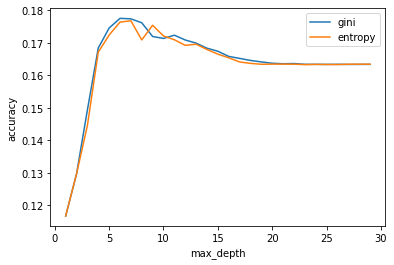

In [27]:
# Find the max depth neccessary for the Decision tree
find_best_max_depth(X_train,y_train,X_test,y_test)

In [28]:
# Method that allow to calculate the decision tree
# syntax:
# X_train: input train dataframe
# y_train: output train dataframe
def dct(X_train, y_train):
    dct = tree.DecisionTreeClassifier()
    
    DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=6,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           class_weight=None)
    
    return dct

In [29]:
# Create Decision tree and fit it
dct = dct(X_train, y_train)
dct.fit(X_train, y_train)

DecisionTreeClassifier()

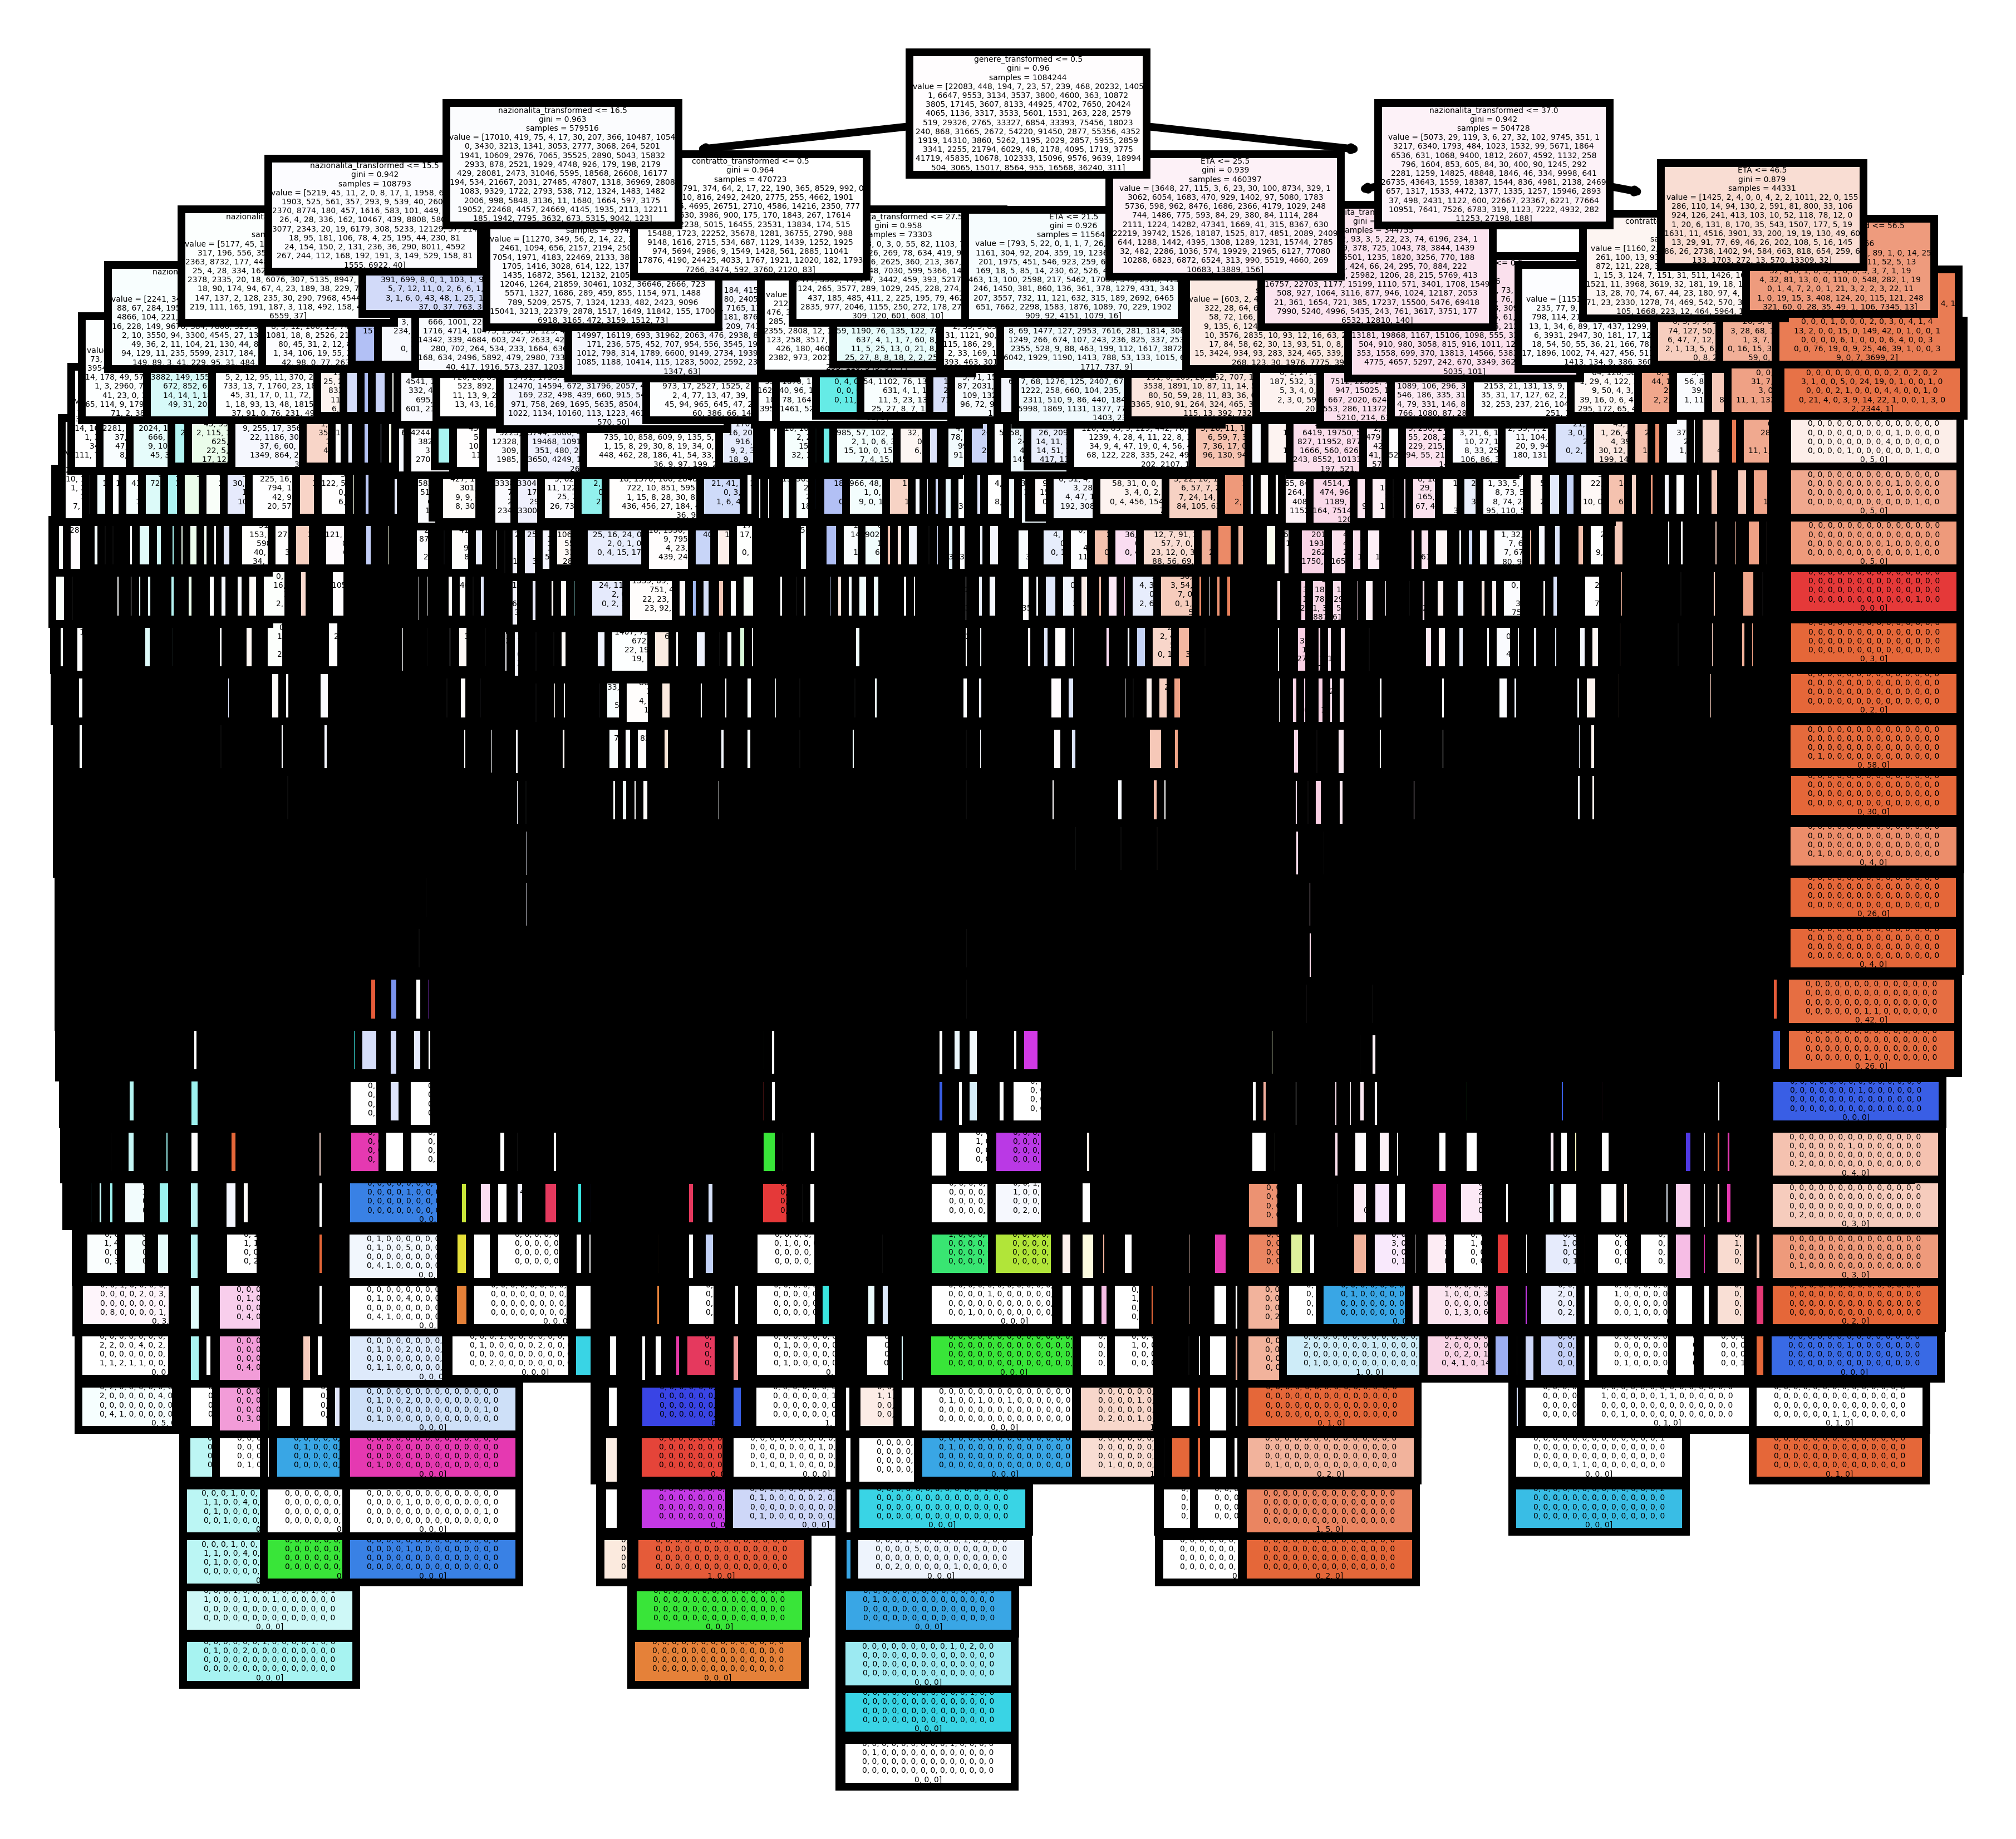

In [30]:
# Show Decision tree
plt.figure(figsize=(4,4), dpi=1000)
plot_tree(dct,
         feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"],
          filled=True,)

plt.show()

In [ ]:
# Probablistic prediction the values
y_pred_prob = dct.predict_proba(X_test)
print(y_pred_prob)

[[0.01872659 0.00374532 0.         ... 0.01123596 0.00374532 0.        ]
 [0.00722022 0.         0.         ... 0.00120337 0.         0.        ]
 [0.01372549 0.         0.         ... 0.01470588 0.00588235 0.        ]
 ...
 [0.00215517 0.         0.         ... 0.01508621 0.         0.        ]
 [0.00923788 0.         0.         ... 0.00923788 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
# Predict the values
y_pred = dct.predict(X_test)
print(y_pred)

[53 62 85 ... 85 41 41]


#### Confusion matrix

In [ ]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred=y_pred.astype(np.uint8)

In [ ]:
# Print the confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

[[ 936    0    0 ...   17  385    0]
 [   8    0    0 ...    0    0    0]
 [   2    0    2 ...    0    1    0]
 ...
 [  63    0    0 ... 2511  132    0]
 [ 594    0    1 ...  814 4807   12]
 [   5    0    0 ...    2   21    0]]


In [ ]:
# Normalization to optimize the results
normalized = preprocessing.normalize(confusion)

In [ ]:
# Show the confusion matrix
fig=px.imshow(normalized,color_continuous_scale='blues')
fig.show()

#### Our prediction

In [ ]:
# Prediction with our data: 
    #23 = age
    #2021 = year in which you want the contract
    #1 = indefinite contract
    #27 = Italy 
    #1 = female
X_mie=[[23,2021,1,27,1]]

In [ ]:
# Probablistic prediction the values
y_pred_prob_mie = dct.predict_proba(X_mie)
print(y_pred_prob_mie)
y_pred_prob_mie = pd.DataFrame(y_pred_prob_mie)
y_conv=pd.DataFrame(dct.classes_)
app= pd.concat([y_pred_prob_mie,y_conv], axis=1)
df=pd.DataFrame(app)
df= df.dropna()
df=df.loc[:, (df != 0).any(axis=0)]

if (df.iloc[: , -1:].columns == 0):
    df = df.iloc[: , :-1]
    
df 

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.01302083 0.         0.         0.00260417
  0.00520833 0.         0.         0.00260417 0.00260417 0.
  0.0078125  0.00520833 0.01822917 0.         0.         0.03125
  0.00260417 0.00520833 0.01302083 0.01041667 0.         0.00520833
  0.00260417 0.         0.         0.         0.         0.
  0.         0.00520833 0.         0.01041667 0.00260417 0.03125
  0.05989583 0.015625   0.         0.00260417 0.02864583 0.02604167
  0.0078125  0.0859375  0.00260417 0.         0.00260417 0.00260417
  0.03385417 0.0078125  0.015625   0.         0.0078125  0.0078125
  0.02083333 0.0078125  0.0078125  0.00260417 0.00260417 0.0078125
  0.         0.         0.         0.00260417 0.         0.00260417
  0.0078125  0.01822917 0.02083333 0.26041667 0.02604167 0.07552083
  0.         0.         0.         0.         0.0078125  0.
  0.04427083 0.         0.        ]]


8         11        12        15        16        18        19  \
0  0.013021  0.002604  0.005208  0.002604  0.002604  0.007812  0.005208   

         20       23        24  ...        69        71        72        73  \
0  0.018229  0.03125  0.002604  ...  0.002604  0.002604  0.007812  0.018229   

         74        75        76        77        82        84  
0  0.020833  0.260417  0.026042  0.075521  0.007812  0.044271  

[1 rows x 50 columns]

In [ ]:
# Sectors in which there is a possibility to get a new contract
sett_pred = []
for x in df.columns:
    el = ateco[ateco["Codice_ateco"] == str(x)]
    sett_pred.extend(el["SETTOREECONOMICODETTAGLIO"])
sett_pred

['INDUSTRIA DELLE BEVANDE',
 'INDUSTRIA DEL TABACCO',
 'FABBRICAZIONE DI ARTICOLI IN PELLE E SIMILI',
 'INDUSTRIA DEL LEGNO E DEI PRODOTTI IN LEGNO E SUGHERO (ESCLUSI I MOBILI); FABBRICAZIONE DI ARTICOLI IN PAGLIA E MATERIALI DA INTRECCIO',
 'STAMPA E RIPRODUZIONE DI SUPPORTI REGISTRATI',
 'FABBRICAZIONE DI COKE E PRODOTTI DERIVANTI DALLA RAFFINAZIONE DEL PETROLIO',
 'FABBRICAZIONE DI PRODOTTI CHIMICI',
 'FABBRICAZIONE DI ALTRI PRODOTTI DELLA LAVORAZIONE DI MINERALI NON METALLIFERI',
 'METALLURGIA',
 'FABBRICAZIONE DI PRODOTTI IN METALLO (ESCLUSI MACCHINARI E ATTREZZATURE)',
 'FABBRICAZIONE DI COMPUTER E PRODOTTI DI ELETTRONICA E OTTICA; APPARECCHI ELETTROMEDICALI, APPARECCHI DI MISURAZIONE E DI OROLOGI',
 'FABBRICAZIONE DI APPARECCHIATURE ELETTRICHE ED APPARECCHIATURE PER USO DOMESTICO NON ELETTRICHE',
 'FABBRICAZIONE DI AUTOVEICOLI, RIMORCHI E SEMIRIMORCHI',
 'FABBRICAZIONE DI ALTRI MEZZI DI TRASPORTO',
 'GESTIONE DELLE RETI FOGNARIE',
 'ATTIVITÀ DI RISANAMENTO E ALTRI SERVIZI DI GES

#### What if we were males? 

In [ ]:
# Prediction with our data: 
    #23 = age
    #2021 = year in which you want the contract
    #1 = indefinite contract
    #27 = Italy 
    #0 = male
X_male=[[23,2021,1,27,0]]

In [ ]:
# Probablistic prediction the values
y_pred_prob_male = dct.predict_proba(X_male)
print(y_pred_prob_male)
y_pred_prob_male = pd.DataFrame(y_pred_prob_male)
y_conv=pd.DataFrame(dct.classes_)
app= pd.concat([y_pred_prob_male,y_conv], axis=1)
df=pd.DataFrame(app)
df= df.dropna()
df=df.loc[:, (df != 0).any(axis=0)]

if (df.iloc[: , -1:].columns == 0):
    df = df.iloc[: , :-1]
    
df 

[[0.00568182 0.         0.         0.         0.         0.
  0.         0.         0.01325758 0.         0.         0.00378788
  0.00189394 0.         0.00189394 0.00568182 0.00378788 0.
  0.02083333 0.00378788 0.03598485 0.0094697  0.00757576 0.06818182
  0.00568182 0.01515152 0.07386364 0.01136364 0.00568182 0.00378788
  0.00568182 0.0094697  0.00189394 0.00378788 0.         0.0094697
  0.         0.01704545 0.00568182 0.04356061 0.01515152 0.05681818
  0.02651515 0.02840909 0.         0.00189394 0.02840909 0.09280303
  0.00189394 0.05681818 0.00378788 0.00189394 0.         0.
  0.11363636 0.00568182 0.01325758 0.         0.0094697  0.00189394
  0.00378788 0.00568182 0.00568182 0.00378788 0.00568182 0.00378788
  0.         0.00568182 0.00189394 0.         0.00378788 0.01515152
  0.01325758 0.02272727 0.         0.03030303 0.00189394 0.00757576
  0.00189394 0.         0.         0.00378788 0.00189394 0.00189394
  0.00568182 0.00189394 0.        ]]


0         8         11        12        14        15        16  \
0  0.005682  0.013258  0.003788  0.001894  0.001894  0.005682  0.003788   

         18        19        20  ...        73        75        76        77  \
0  0.020833  0.003788  0.035985  ...  0.022727  0.030303  0.001894  0.007576   

         78        81        82        83        84        85  
0  0.001894  0.003788  0.001894  0.001894  0.005682  0.001894  

[1 rows x 64 columns]

In [ ]:
# Sectors in which there is a possibility to get a new contract
sett_pred = []
for x in df.columns:
    el = ateco[ateco["Codice_ateco"] == str(x)]
    sett_pred.extend(el["SETTOREECONOMICODETTAGLIO"])
sett_pred

['INDUSTRIA DELLE BEVANDE',
 'INDUSTRIA DEL TABACCO',
 'CONFEZIONE DI ARTICOLI DI ABBIGLIAMENTO; CONFEZIONE DI ARTICOLI IN PELLE E PELLICCIA',
 'FABBRICAZIONE DI ARTICOLI IN PELLE E SIMILI',
 'INDUSTRIA DEL LEGNO E DEI PRODOTTI IN LEGNO E SUGHERO (ESCLUSI I MOBILI); FABBRICAZIONE DI ARTICOLI IN PAGLIA E MATERIALI DA INTRECCIO',
 'STAMPA E RIPRODUZIONE DI SUPPORTI REGISTRATI',
 'FABBRICAZIONE DI COKE E PRODOTTI DERIVANTI DALLA RAFFINAZIONE DEL PETROLIO',
 'FABBRICAZIONE DI PRODOTTI CHIMICI',
 'FABBRICAZIONE DI PRODOTTI FARMACEUTICI DI BASE E DI PREPARATI FARMACEUTICI',
 'FABBRICAZIONE DI ARTICOLI IN GOMMA E MATERIE PLASTICHE',
 'FABBRICAZIONE DI ALTRI PRODOTTI DELLA LAVORAZIONE DI MINERALI NON METALLIFERI',
 'METALLURGIA',
 'FABBRICAZIONE DI PRODOTTI IN METALLO (ESCLUSI MACCHINARI E ATTREZZATURE)',
 'FABBRICAZIONE DI COMPUTER E PRODOTTI DI ELETTRONICA E OTTICA; APPARECCHI ELETTROMEDICALI, APPARECCHI DI MISURAZIONE E DI OROLOGI',
 'FABBRICAZIONE DI APPARECCHIATURE ELETTRICHE ED APPARECCH

#### Best Depth Tree

In [ ]:
# Calculate the max depth in the decision tree
max_depth = dct.get_depth()

# Find the best parameter
max_depth_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                                    scoring=make_scorer(accuracy_score),
                                    param_grid=ParameterGrid({"max_depth":[[max_depth] for max_depth in range(1, max_depth+1)]}),)
max_depth_grid_search.fit(X_train, y_train)

# Show the tree with the parameter found previuosly 
best_max_depth_tree=max_depth_grid_search.best_estimator_
best_max_depth = best_max_depth_tree.get_depth()

In [ ]:
plt.figure(figsize=(4,4), dpi=1000)
plot_tree(best_max_depth_tree,
         feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"],
          filled=True,)

plt.show()

In [ ]:
# Show the best parameter
print(max_depth_grid_search.best_params_)

{'max_depth': 12}


## K-Nearest Neighbors Classification

In [ ]:
# Apply the function 
[X_train, X_test]=scaleFeaturesDF(X_train, X_test)

# Find the model of K-Nearest Neighbors and fit it
knmodel = KNeighborsClassifier(n_neighbors =5, weights='uniform')
knmodel.fit(X_train, y_train)

# Predict using KNN
y_pred = knmodel.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = sqrt(mse)

# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred=y_pred.astype(np.uint8)

In [ ]:
# Print the confusion matrix
confusion = metrics.confusion_matrix(y_train, y_pred)
print(confusion)

In [ ]:
# Normalization to optimize the results
normalized = preprocessing.normalize(confusion)

In [ ]:
# Show the confusion matrix 
fig=px.imshow(normalized,color_continuous_scale='blues')
fig.show()

## Future Prediction

### Predict number of contracts. Is the number of contracts predicted for the future in 2019 the same or similar to the actual data given the occurrence of COVID?

## ARIMA

In [ ]:
# Load the dataset
balanced
bal1 = balanced.copy()
bal1 = bal1.reset_index(drop=True)

# Set mese-anno like index
bal2 = bal1.groupby("mese-anno").size().reset_index(name='count')
bal2 = bal2.set_index('mese-anno')

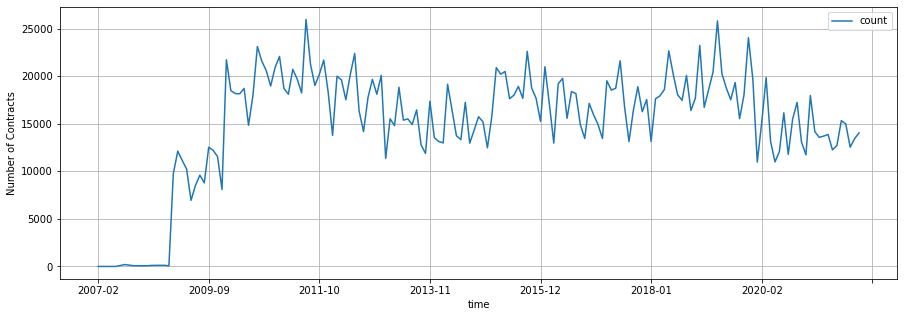

In [ ]:
# Show count of contract for each mese-anno
f, ax1 = plt.subplots(1,1,figsize=(15,5))
bal2.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")
plt.grid(True)

In [ ]:
# Calculate the Augmented Dickey-Fuller test can be used to test for a unit root in a univariate 
#process in the presence of serial correlation.
results = adfuller(bal2['count'])

In [ ]:
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -4.613666
p-value: 0.000122


In [ ]:
# Show seasonality and trend
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(bal2, model="additive", period=5)

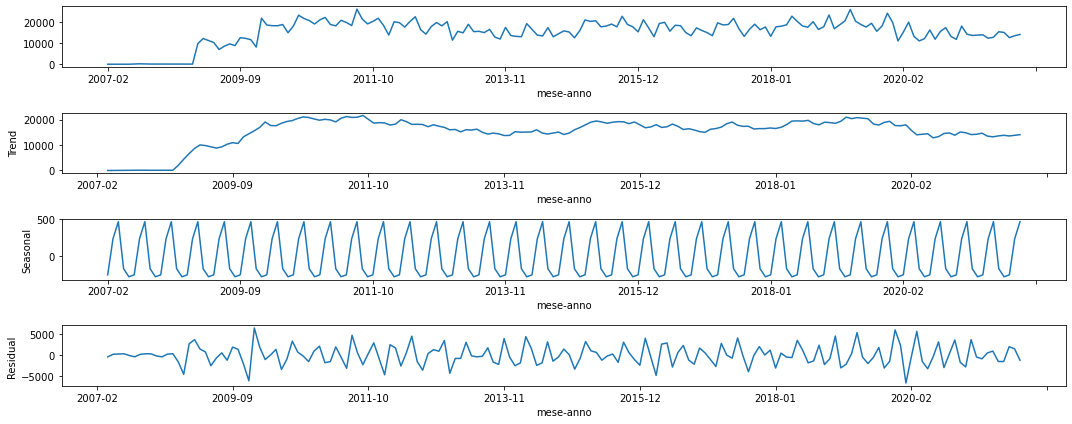

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(15, 6))
decomposed_add.observed.plot(ax = ax[0])
decomposed_add.trend.plot(ax = ax[1])
decomposed_add.seasonal.plot(ax = ax[2])
decomposed_add.resid.plot(ax = ax[3])
ax[0].set_ylabel('')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate differential
bal_diff = bal2['count'].diff().dropna()

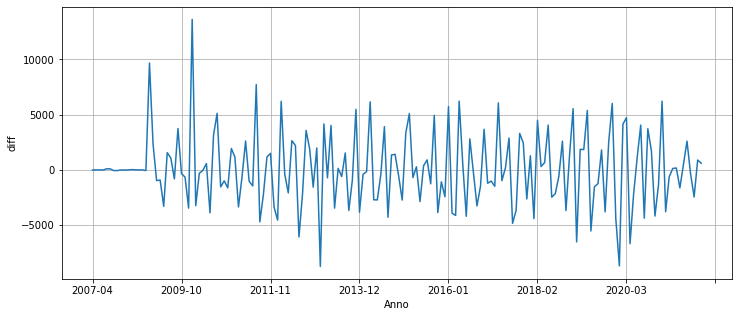

In [ ]:
plt.figure(figsize=(12,5))
ax1 = bal_diff.plot()
ax1.set_xlabel("Anno")
ax1.set_ylabel("diff")
plt.grid(True)
plt.show()

In [ ]:
# Calculate the Augmented Dickey-Fuller test

results = adfuller(bal_diff)

In [ ]:
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -2.987232
p-value: 0.036104


In [ ]:
# Calculate the Augmented Dickey-Fuller test
results = adfuller(bal2['count'].diff().diff().dropna())

In [ ]:
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -7.801078
P-value of a test is: 7.490497084599864e-12


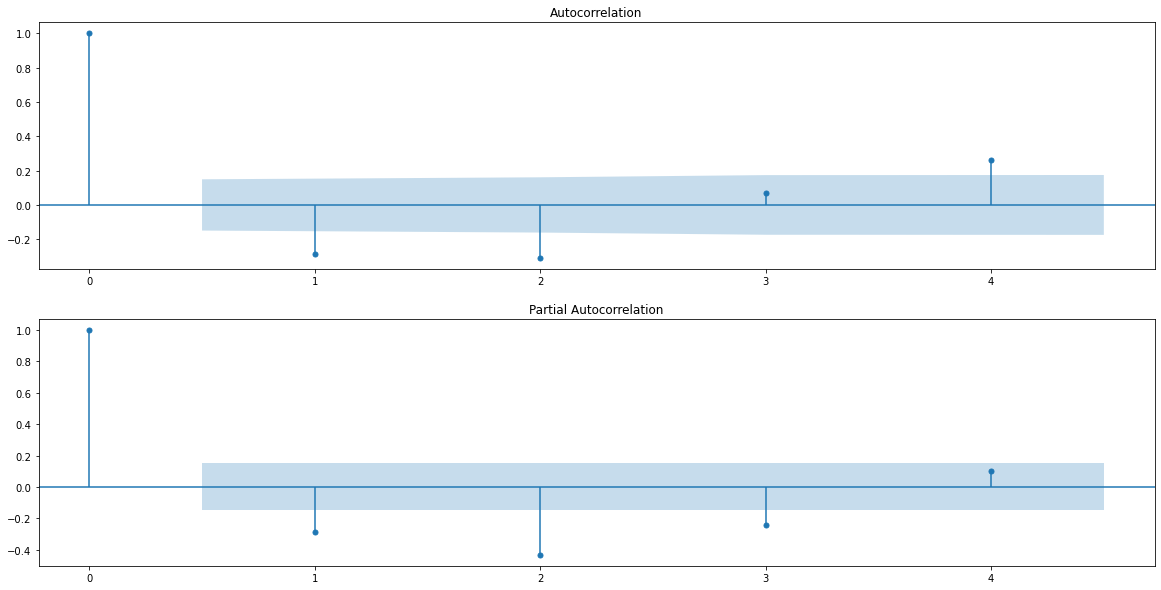

In [ ]:
# Show autocorrelation and partial correlation
fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(bal_diff, lags=4, ax=ax[0])
plot_pacf(bal_diff, lags=4, ax=ax[1])
plt.show()

In [ ]:
arima_df = arima_aic(bal2)
arima_df

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53563D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   9.536D+00
  F =   9.5356311497057664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  9.38225D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   0.000D+00   9.382D+00
  F =   9.3822507141105049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49349D+00    |proj g|=  8.28138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   0.000D+00   9.392D+00
  F =   9.3916740930360216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36722D+00    |proj g|=  1.61098D-03

At iterate    5    f=  9.36719D+00    |proj g|=  5.55289D-04

At iterate   10    f=  9.36719D+00    |proj g|=  7.10543D-06

At iterate   15    f=  9.36719D+00    |proj g|=  1.41398D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     43      1     0     0   1.776D-07   9.367D+00
  F =   9.3671181930709899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39460D+00    |proj g|=  2.46381D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  9.37142D+00    |proj g|=  3.49942D-05

At iterate   40    f=  9.37142D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     58      1     0     0   3.553D-07   9.371D+00
  F =   9.3714200543317165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37136D+00    |proj g|=  2.41887D-03

At iterate    5    f=  9.37134D+00    |proj g|=  1.66800D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36681D+00    |proj g|=  2.47837D-03

At iterate    5    f=  9.36679D+00    |proj g|=  8.88179D-07

At iterate   10    f=  9.36679D+00    |proj g|=  2.59348D-05

At iterate   15    f=  9.36679D+00    |proj g|=  9.36140D-05

At iterate   20    f=  9.36679D+00    |proj g|=  1.77636D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     39      1     0     0   7.105D-07   9.367D+00
  F =   9.3667912594171181     

CONVERG

 This problem is unconstrained.


p  q          aic          bic  sum_aic_bic
0   0  0  3284.257115  3290.552104   6574.80922
4   1  0  3271.761418  3281.203902   6552.96532
1   0  1  3243.140917    3252.5834  6495.724317
5   1  1  3242.871819  3255.461797  6498.333616
6   1  2  3240.735888   3256.47336  6497.209248
2   0  2   3240.38273  3252.972708  6493.355439
8   2  0  3239.736714  3252.326692  6492.063406
3   0  3  3237.494246  3253.231718  6490.725964
10  2  2  3235.741516  3254.626483  6490.367999
7   1  3  3234.288658  3253.173625  6487.462284
9   2  1  3233.768499  3249.505971   6483.27447
12  3  0  3232.176193  3247.913666  6480.089859
13  3  1  3230.708967  3249.593934    6480.3029
15  3  3  3228.650839  3253.830794  6482.481633

In [ ]:
# Compute the model
model2 = SARIMAX(bal2, order=(3,1,3), seasonal_order=(0,1,0,6))
results = model2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24501D+00    |proj g|=  2.13318D-01

At iterate    5    f=  9.19526D+00    |proj g|=  1.03799D-01

At iterate   10    f=  9.17928D+00    |proj g|=  7.65491D-03

At iterate   15    f=  9.17635D+00    |proj g|=  6.98888D-02

At iterate   20    f=  9.17001D+00    |proj g|=  1.50223D-02

At iterate   25    f=  9.16991D+00    |proj g|=  1.77395D-03


 This problem is unconstrained.



At iterate   30    f=  9.16983D+00    |proj g|=  7.74047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     39      1     0     0   5.977D-05   9.170D+00
  F =   9.1698112434568877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [ ]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              count   No. Observations:                  173
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 6)   Log Likelihood               -1586.377
Date:                            Wed, 01 Jun 2022   AIC                           3186.755
Time:                                    11:04:59   BIC                           3208.539
Sample:                                         0   HQIC                          3195.597
                                            - 173                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6172      0.135     -4.588      0.000      -0.881      -0.354
ar.L2         -0.8422      0.104   

In [ ]:
# Show the parameters
plt.rcParams['figure.figsize'] = 12, 8

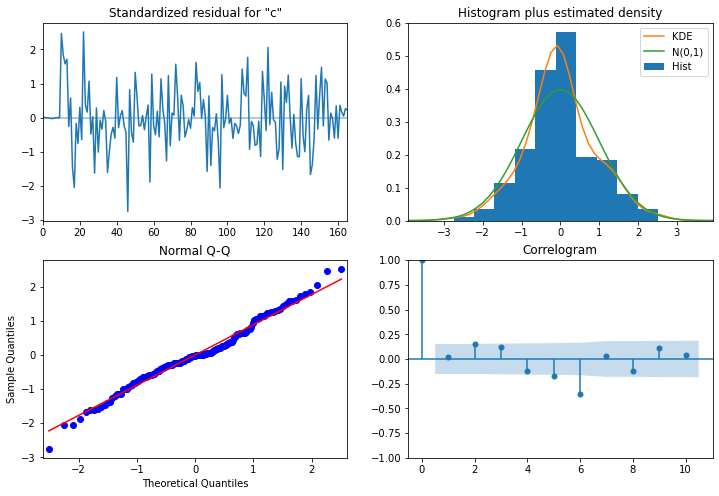

In [ ]:
plot = results.plot_diagnostics()

In [ ]:
# Prediction of the future

# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

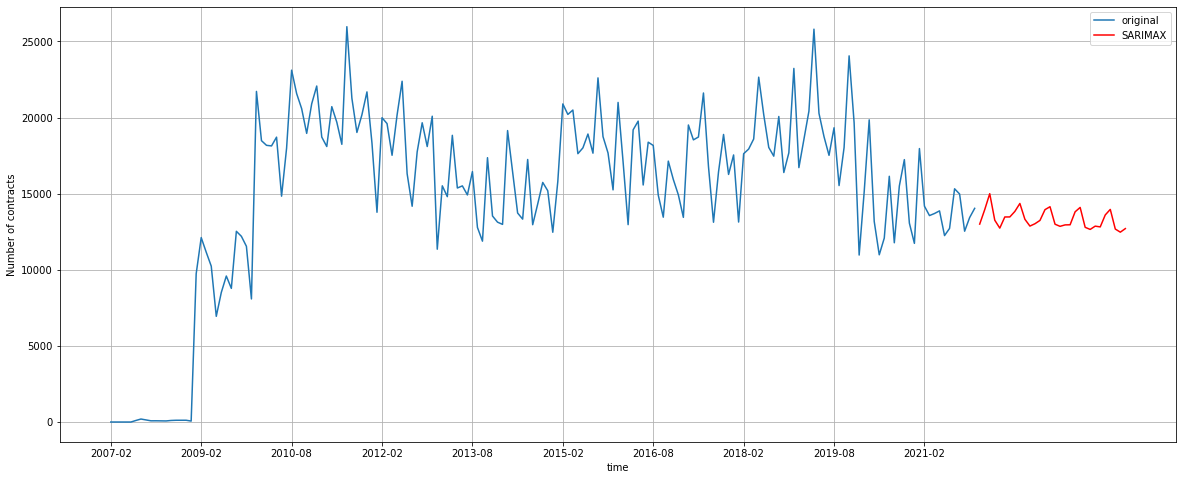

In [ ]:
# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,8))
plt.plot(bal2, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.legend()
plt.grid(True)
plt.show()

## Model Validation

In [ ]:
# Featuring engineering
# Lag features and Shift index
for i in range(1,3):
    lag_i = 'lag_' + str(i)
    bal2[lag_i] = bal2['count'].shift(i)
    
# Rolling window
bal2['rolling_mean'] = bal2['count'].rolling(window=2).mean()
bal2['rolling_max'] = bal2['count'].rolling(window=2).max()
bal2['rolling_min'] = bal2['count'].rolling(window=2).min()

# Inference: count is less correlated with lag_1 and lag_2. Hence removing them from dataset.
bal2 = bal2[["rolling_mean","rolling_max", "rolling_min", "count"]]

# Fill NaN values with mean value
bal2.fillna(bal2.mean(), inplace = True)

# Split the time series data (Train-80, Test-20)
contract_train = bal2.iloc[0:138]               
contract_test = bal2.iloc[138:]

contract_pred_train = bal2.iloc[0:138]               
contract_pred_test = bal2.iloc[138:]

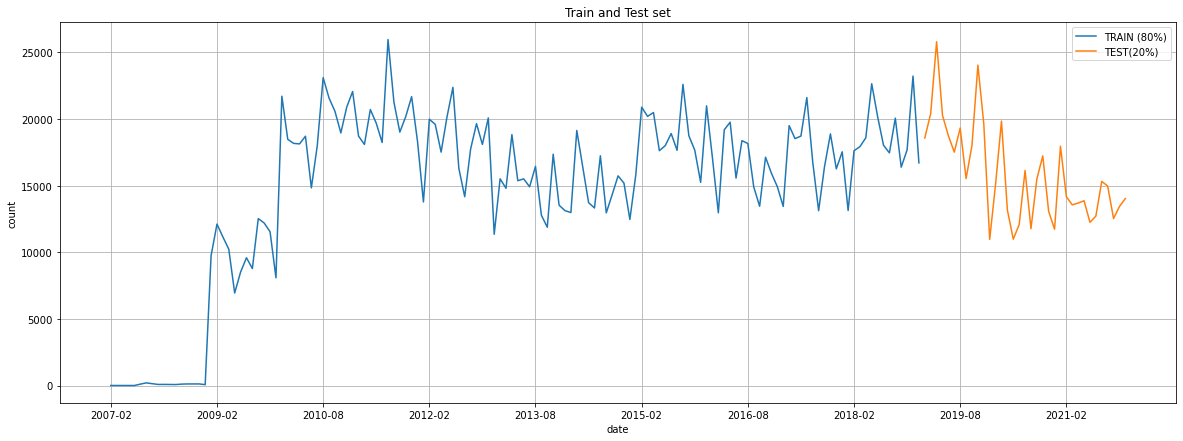

In [ ]:
# Plot train and test sets
plt.subplots(1,1,figsize=(20,7))
plt.plot(contract_train['count'],label='TRAIN (80%)')
plt.plot(contract_test['count'], label='TEST(20%)')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Train and Test set')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.grid(True)
plt.show()

### Holt winter

In [ ]:
# Delete the feature to predict
X_train = contract_train.drop(['count'], axis=1)
y_train = contract_train['count'].values

X_test = contract_test.drop(['count'], axis=1)
y_test = contract_test['count'].values

In [ ]:
# Modeling the simple exponential smoothing
ses_model = SimpleExpSmoothing(contract_train['count']).fit(smoothing_level=0.3)
ses_preds = ses_model.forecast(steps = 35) 

# Calculate the errors
ses_errors_df = contract_test[['count']]
ses_errors_df['Predicted_Count'] = ses_preds.values
ses_errors_df['Error'] = ses_preds.values - y_test
ses_errors_df.insert(0, 'Modelname', 'Holtman- SES')

# Modeling the double exponential smoothing
double_model = ExponentialSmoothing(contract_train['count'],trend='add').fit()
doublemodel_preds = double_model.forecast(35).rename('DES Forecast')

# Calculate the errors
des_errors_df = contract_test[['count']]
des_errors_df['Predicted_Count'] = doublemodel_preds.values
des_errors_df['Error'] = doublemodel_preds.values - y_test
des_errors_df.insert(0, 'Modelname', 'Holtman- DES')


# Modeling the triple exponential smoothing
triple_model = ExponentialSmoothing(contract_train['count'],trend='add', seasonal= 'mul',seasonal_periods= 12).fit(use_boxcox=False, remove_bias=False)
tes_forecast = triple_model.forecast(35).rename('TES_Forecast')

# Calculate the errors
tes_errors_df = contract_test[['count']]
tes_errors_df['Predicted_Count'] = tes_forecast.values
tes_errors_df['Error'] = tes_forecast.values - y_test
tes_errors_df.insert(0, 'Modelname', 'Holtman- TES')


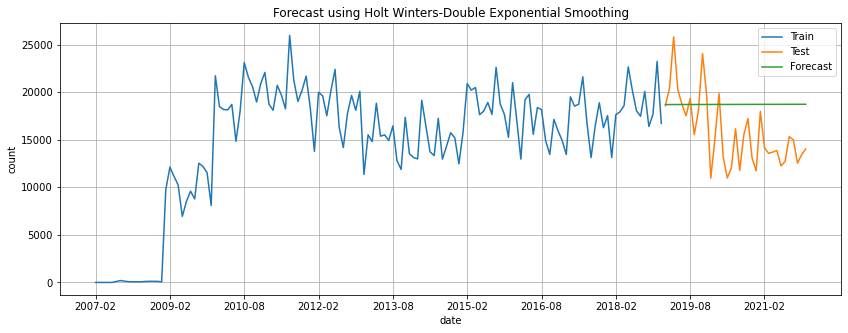

In [ ]:
# Plot the number of contract using holtman forecast model using Double Exponential Smoothing
fig = plt.figure(figsize=(14,5))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(des_errors_df.index, des_errors_df['Predicted_Count'], label='Forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Forecast using Holt Winters-Double Exponential Smoothing')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.grid(True)
plt.show()

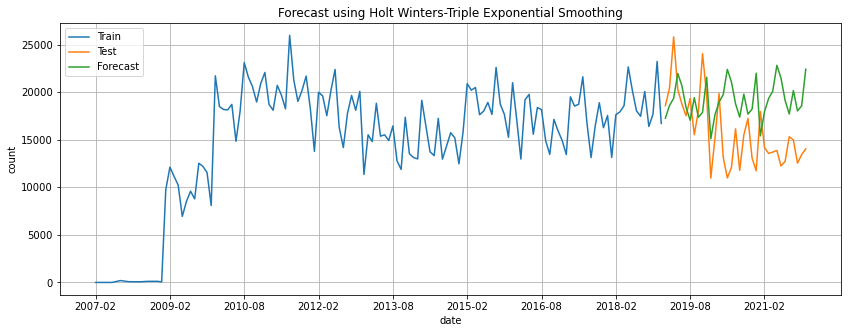

In [ ]:
# Plot the number of contract using holtman forecast model using Triple Exponential Smoothing
fig= plt.figure(figsize=(14,5))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(tes_errors_df.index, tes_errors_df['Predicted_Count'], label='Forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Forecast using Holt Winters-Triple Exponential Smoothing')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.grid(True)
plt.show()

### Extra trees regressor

In [ ]:
# Fit model
etr_model = ExtraTreesRegressor(n_estimators=100)
etr_model.fit(X_train, y_train)

# Start the prediction
etr_preds = etr_model.predict(X_test)

In [ ]:
# Check the score for the train and test sets
print('Model Score at Train set: {:.2%}'.format(etr_model.score(X_train, y_train)))
print('Model Score at Test set: {:.2%}'.format(etr_model.score(X_test, y_test)))

Model Score at Train set: 100.00%
Model Score at Test set: 72.51%


In [ ]:
# Calculate the errors
etr_errors_df = contract_test[['count']]
etr_errors_df['Predicted_Count'] = etr_preds
etr_errors_df['Error'] = etr_preds - y_test
etr_errors_df.insert(0, 'Modelname', 'ExtreeTreesRegressor')

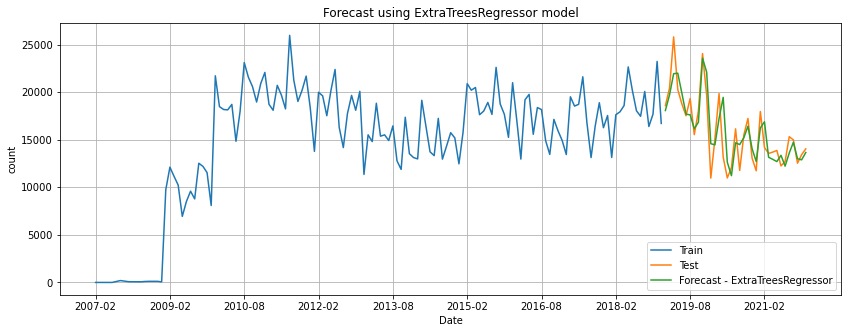

In [ ]:
# Show the predictions for Extra Tree Regressor
fig = plt.figure(figsize=(14,5))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(etr_errors_df.index, etr_errors_df['Predicted_Count'], label='Forecast - ExtraTreesRegressor')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using ExtraTreesRegressor model')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.grid(True)
plt.show()

### Linear regression

In [ ]:
# Fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Start the prediction
lr_preds = lr_model.predict(X_test)

# Calculate the errors
lr_errors_df = contract_test[['count']]
lr_errors_df['Predicted_Count'] = lr_preds
lr_errors_df['Error'] = lr_preds - y_test
lr_errors_df.insert(0, 'Modelname', 'Linear Regression')

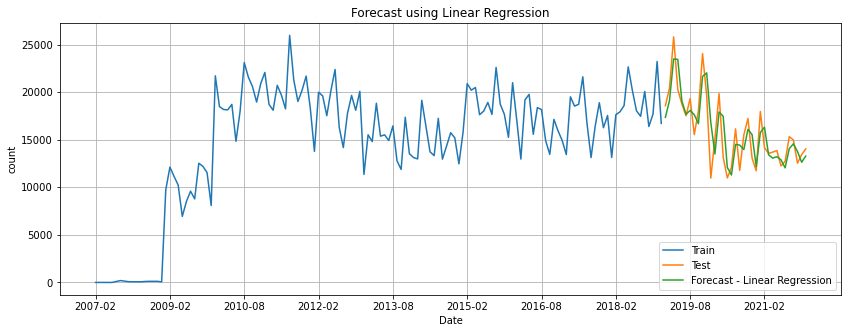

In [ ]:
# Show the predictions for Linear Regression
fig = plt.figure(figsize=(14,5))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(lr_errors_df.index, lr_errors_df['Predicted_Count'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using Linear Regression')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.grid(True)
plt.show()

### ARIMA e SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95179D+00    |proj g|=  9.99835D-02


 This problem is unconstrained.



At iterate    5    f=  6.92423D+00    |proj g|=  6.07726D-02

At iterate   10    f=  6.91555D+00    |proj g|=  8.77752D-02

At iterate   15    f=  6.90862D+00    |proj g|=  2.64234D-01

At iterate   20    f=  6.90623D+00    |proj g|=  1.18934D-01

At iterate   25    f=  6.90475D+00    |proj g|=  1.98346D-01

At iterate   30    f=  6.90322D+00    |proj g|=  1.21653D-02

At iterate   35    f=  6.90285D+00    |proj g|=  9.02239D-02

At iterate   40    f=  6.90218D+00    |proj g|=  1.12459D-01

At iterate   45    f=  6.90145D+00    |proj g|=  5.86443D-02

At iterate   50    f=  6.90096D+00    |proj g|=  2.85205D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

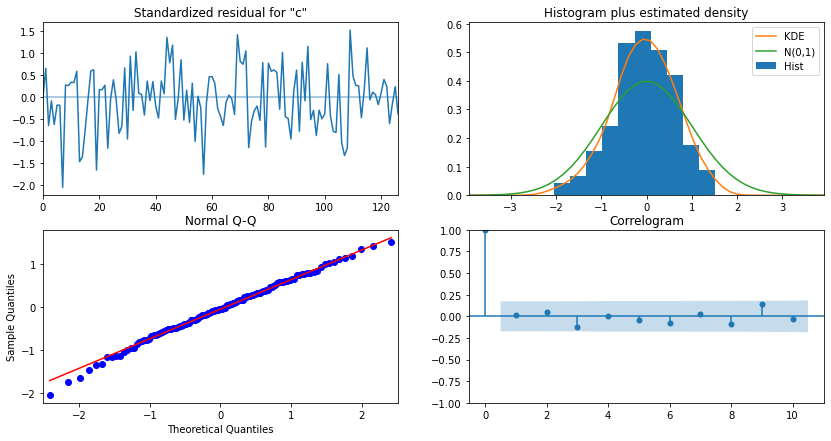

In [ ]:
# Fit the model
arima_model = ARIMA(bal2['count'], (3,1,3)).fit(disp=False)

# Fit the model
sarima_model = SARIMAX(bal2['count'], order=(3, 1, 3), seasonal_order=(6, 1, 0, 6), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
sarima_test_df = contract_test[["count"]]
sarima_test_df['Predicted_Count'] = sarima_fit.predict(start=contract_test.index[0],
                                                 end=contract_test.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))

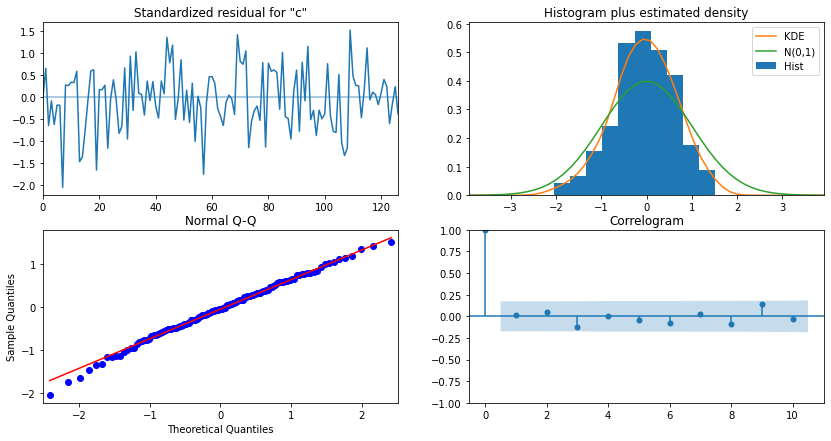

In [ ]:
plot

In [ ]:
# Evaluation of errors
sarima_test_df['Error'] = sarima_test_df['count'] - sarima_test_df.Predicted_Count
sarima_test_df.insert(0, 'Modelname', 'SARIMA')
sarima_test_df.head() 

Modelname  count  Predicted_Count        Error
mese-anno                                               
2019-02      SARIMA  18580     15599.319531  2980.680469
2019-03      SARIMA  20420     19790.440355   629.559645
2019-04      SARIMA  25804     20753.332760  5050.667240
2019-05      SARIMA  20276     19972.388771   303.611229
2019-06      SARIMA  18748     18436.688005   311.311995

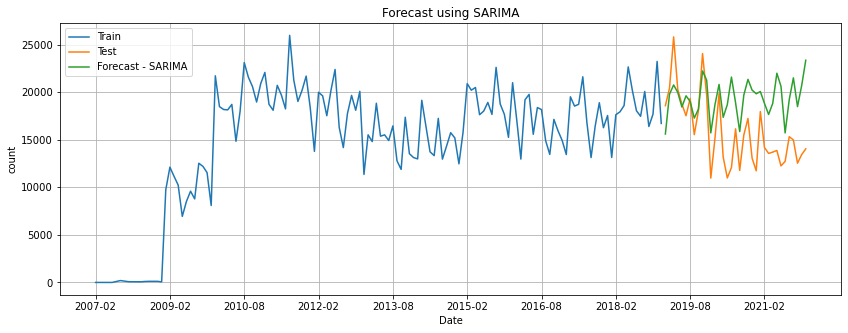

In [ ]:
# Show the predictions for SARIMA model
fig = plt.figure(figsize=(14,5))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(sarima_test_df.index, sarima_test_df['Predicted_Count'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using SARIMA')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.grid(True)
plt.show()

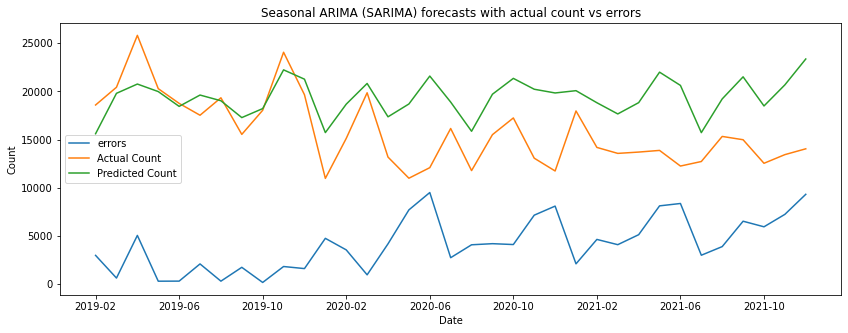

In [ ]:
# Show the errors for the predicted and the actual values
plt.figure(figsize=(14,5))
plt.plot(sarima_test_df.index, np.abs(sarima_test_df['Error']), label='errors')
plt.plot(sarima_test_df.index, sarima_test_df['count'], label='Actual Count')
plt.plot(sarima_test_df.index, sarima_test_df['Predicted_Count'], label='Predicted Count')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual count vs errors')
plt.xticks(sarima_test_df.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### SVR (Support Vector Regressor) regressor

In [ ]:
# Start the prediction
import sklearn
svr_model = sklearn.svm.SVR(kernel='linear', degree=3, C=1.0,).fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)

# Errors calculation
svr_errors_df = contract_test[['count']]
svr_errors_df['Predicted_Count'] = svr_preds
svr_errors_df['Error'] = svr_preds - y_test
svr_errors_df.insert(0, 'Modelname', 'Support Vector Regressor')
svr_errors_df.head() 

Modelname  count  Predicted_Count        Error
mese-anno                                                               
2019-02    Support Vector Regressor  18580     18068.221819  -511.778181
2019-03    Support Vector Regressor  20420     19851.123249  -568.876751
2019-04    Support Vector Regressor  25804     25176.655351  -627.344649
2019-05    Support Vector Regressor  20276     25180.965105  4904.965105
2019-06    Support Vector Regressor  18748     19702.186109   954.186109

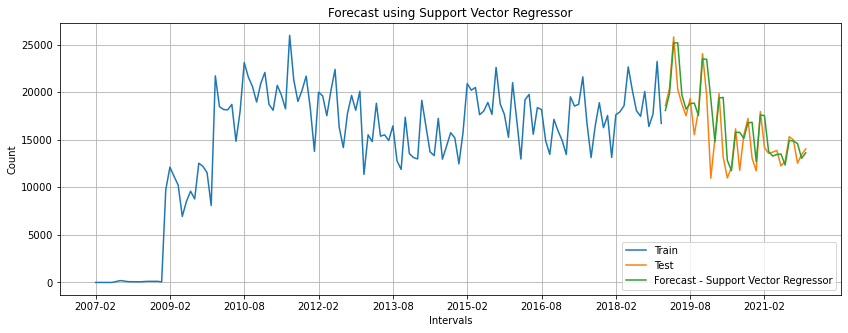

In [ ]:
# Show predictions for Support Vector Regressor
fig = plt.figure(figsize=(14,5))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(svr_errors_df.index, svr_errors_df['Predicted_Count'], label='Forecast - Support Vector Regressor')
plt.legend(loc='best')
plt.xlabel('Intervals')
plt.ylabel('Count')
plt.title('Forecast using Support Vector Regressor')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.grid(True)
plt.show()

## Compare the different models

In [ ]:
# Define metrics

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, count=tes_errors_df['count']):
    return np.sum(np.abs(err))/np.sum(count) * 100

In [ ]:
# Calculate metrics for SVR
result_df_svr = svr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))


# Calculate metrics for SARIMA
result_df_sarima = sarima_test_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))


# Calculate metrics for Holtman Winter
result_df_hw = tes_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))


# Calculate metrics for Linear regression
result_df_lr = lr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))


# Calculate metrics for Extra tree regression
result_df_etr = etr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))


# Create the table with all the previous calculated results
list_objs = [result_df_svr, result_df_lr, result_df_hw, result_df_sarima, result_df_etr]
metrics_table = pd.concat(list_objs)



# Show Prediction of Extra Tree Regressor
etr_prediction = pd.DataFrame(data=etr_preds, columns=['Predicted_Count'])
contract_pred_test.drop(columns= ['rolling_mean','rolling_max','rolling_min'], inplace=True)
contract_pred_test.reset_index(inplace=True)
compare_results = pd.merge(contract_pred_test, etr_prediction, left_index=True, right_index=True)
# Compare the predictions with the real values
compare_results=compare_results.drop(columns='mese-anno')

In [ ]:
metrics_table

Total_Count  Total_Pred_Count  Model_Overall_Error  \
Modelname                                                                      
Support Vector Regressor       554100     591339.950117         37239.950117   
Linear Regression              554100     556990.797802          2890.797802   
Holtman- TES                   554100     671226.045459        117126.045459   
SARIMA                         554100     677672.762120       -123572.762120   
ExtreeTreesRegressor           554100     558054.540000          3954.540000   

                                  MAE         RMSE       MAPE  
Modelname                                                      
Support Vector Regressor  1549.257795  2479.714193   9.785963  
Linear Regression         1569.672280  1956.473486   9.914912  
Holtman- TES              4614.475776  5460.132469  29.147564  
SARIMA                    4182.641275  4993.732693  26.419860  
ExtreeTreesRegressor      1406.727429  1881.467556   8.885663

In [ ]:
# Check of the model
print('Extra Tree Regressor')
print('Model Score at Train set: {:.2%}'.format(etr_model.score(X_train, y_train))) 
print('Model Score at Test set: {:.2%}'.format(etr_model.score(X_test, y_test))) 

Extra Tree Regressor
Model Score at Train set: 100.00%
Model Score at Test set: 72.51%


# Pre COVID Prediction

In [ ]:
# Extract only the elements of the pre COVID years
pre_covid = transformed[transformed['ANNO']<2019]

# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = pre_covid[pre_covid["contratto_transformed"]==0].sample(n=356141,random_state=16)
data_1 = pre_covid[pre_covid["contratto_transformed"]==1]
balanced_pre = data_0.append(data_1)

# Create the train and test sets
X = balanced_pre[["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"]].values
y = pd.DataFrame(balanced_pre['Codice_ateco'].copy()).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

# To avoid the MemoryError, we change the dataset's type into a new lighter one
X_train=X_train.astype(np.uint8)
y_train=y_train.astype(np.uint8)


## Decision Tree

In [ ]:
# Define the Decision Tree
dct = tree.DecisionTreeClassifier()
DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                           max_features=None, 
                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           class_weight=None)

# Create Decision tree and fit it
dct.fit(X_train, y_train)


In [ ]:
plt.figure(figsize=(4,4), dpi=1000)
plot_tree(dct,
         feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"],
          filled=True,)

# Show Decision tree
plt.show()

In [ ]:
# Probablistic prediction the values
y_pred_prob = dct.predict_proba(X_test)
y_pred_prob

In [ ]:
# Predict the values
y_pred = dct.predict(X_test)
y_pred

In [ ]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred=y_pred.astype(np.uint8)

In [ ]:
# Print the confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

In [ ]:
# Normalization to optimize the results
#from sklearn import preprocessing 
normalized = preprocessing.normalize(confusion)

In [ ]:
# Show the confusion matrix
fig=px.imshow(normalized,color_continuous_scale='blues')
fig.show()

## ARIMA

In [ ]:
# Load the dataset
balanced1 = balanced_pre.copy()
balanced1 = balanced1.reset_index(drop=True)

# Set mese-anno like index
# Show count of contract for each mese-anno
balanced2 = balanced1.groupby("mese-anno").size().reset_index(name='count')
balanced2 = balanced2.set_index('mese-anno')

Text(0, 0.5, 'Number of Contracts')

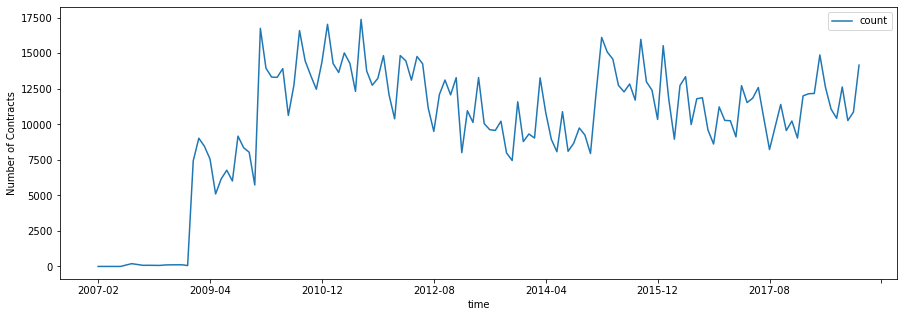

In [ ]:
f, ax1 = plt.subplots(1,1,figsize=(15,5))
balanced2.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")

In [ ]:
# Calculate the Augmented Dickey-Fuller test can be used to test for a unit root in a univariate 
#process in the presence of serial correlation.
results = adfuller(balanced2['count'])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -3.504387
p-value: 0.007875


In [ ]:
# Show seasonality and trend
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(balanced2, model="additive", period=5)

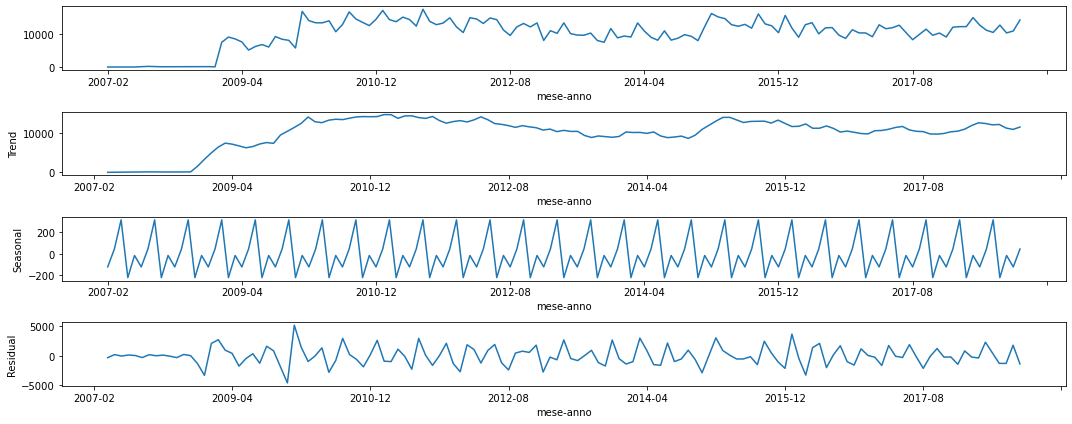

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(15, 6))
# Plot the series
decomposed_add.observed.plot(ax = ax[0])
decomposed_add.trend.plot(ax = ax[1])
decomposed_add.seasonal.plot(ax = ax[2])
decomposed_add.resid.plot(ax = ax[3])
# Add the labels to the Y-axis
ax[0].set_ylabel('')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [ ]:
arima_df = arima_aic(balanced2)
arima_df

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18383D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   9.184D+00
  F =   9.1838298314262747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07166D+00    |proj g|=  1.95630D-03

At iterate    5    f=  9.07164D+00    |proj g|=  3.55272D-07

At iterate   10    f=  9.07164D+00    |proj g|=  2.48690D-06

At iterate   15    f=  9.07164D+00    |proj g|=  5.41789D-05

At iterate   20    f=  9.07164D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   1.776D-07   9.072D+00
  F =   9.0716437664765763     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06863D+00    |proj g|=  2.33129D-03

At iterate    5    f=  9.06861D+00    |proj g|=  1.03384D-04

At iterate   10    f=  9.06861D+00    |proj g|=  1.42109D-06

At iterate   15    f=  9.06861D+00    |proj g|=  2.41585D-05

At iterate   20    f=  9.06861D+00    |proj g|=  2.25597D-05

At iterate   25    f=  9.06861D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     41      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  9.06474D+00    |proj g|=  7.49623D-05

At iterate   20    f=  9.06474D+00    |proj g|=  1.11910D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   1.776D-07   9.065D+00
  F =   9.0647364237773278     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05508D+00    |proj g|=  3.69145D-03

At iterate    5    f=  9.05504D+00    |proj g|=  7.24754D-05

At itera

 This problem is unconstrained.


p  q          aic          bic  sum_aic_bic
0   0  0  2502.001714  2507.827024  5009.828738
4   1  0  2491.176986  2499.914951  4991.091937
8   2  0  2479.701064  2491.351683  4971.052747
10  2  2  2478.662819  2496.138748  4974.801567
6   1  2  2477.720877  2492.284152  4970.005029
3   0  3  2477.487104  2492.050379  4969.537483
1   0  1  2476.980355  2485.718319  4962.698674
5   1  1  2476.754321   2488.40494  4965.159261
9   2  1   2476.66713  2491.230405  4967.897535
2   0  2  2475.886333  2487.536952  4963.423285
12  3  0  2475.608307  2490.171582  4965.779889
13  3  1  2474.972059  2492.447988  4967.420047

In [ ]:
# Compute the model
model2 = SARIMAX(balanced2, order=(3,1,3), seasonal_order=(0,1,0,6))
results = model2.fit()
print(results.summary())

# Show the parameters
plt.rcParams['figure.figsize'] = 12, 8

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.90909D+00    |proj g|=  2.14336D-01

At iterate    5    f=  8.84287D+00    |proj g|=  9.14197D-02

At iterate   10    f=  8.82320D+00    |proj g|=  2.27804D-02

At iterate   15    f=  8.80897D+00    |proj g|=  2.48608D-02

At iterate   20    f=  8.80848D+00    |proj g|=  3.29911D-03

At iterate   25    f=  8.80846D+00    |proj g|=  4.29537D-03

At iterate   30    f=  8.80842D+00    |proj g|=  4.09190D-04

At iterate   35    f=  8.80842D+00    |proj g|=  8.01760D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

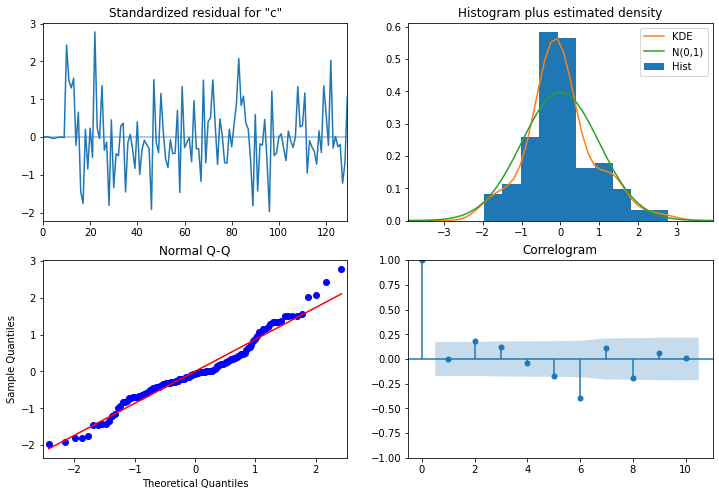

In [ ]:
plot = results.plot_diagnostics()

In [ ]:
# Prediction of the future

# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

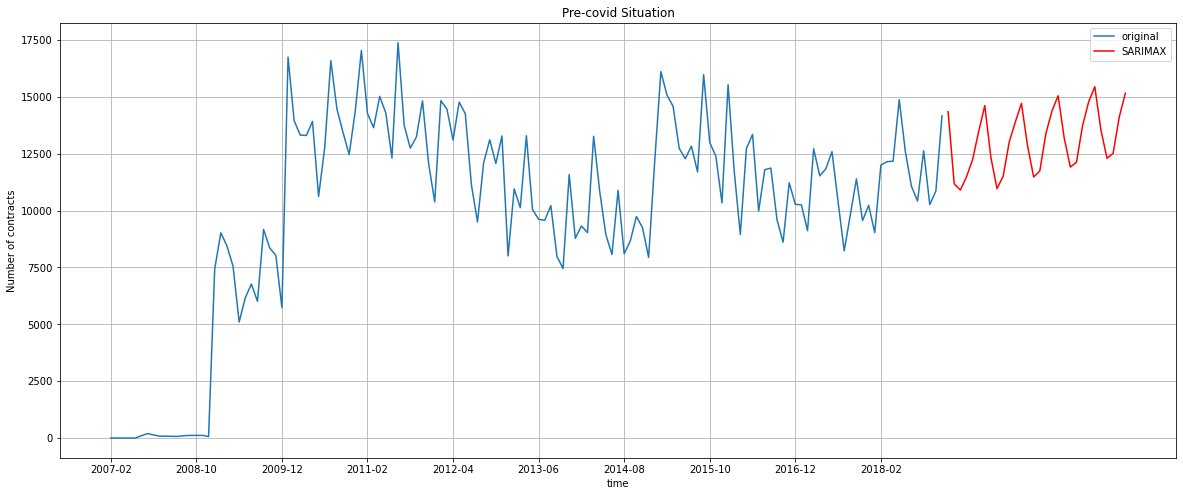

In [ ]:
# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,8))
plt.plot(balanced2, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")
plt.xticks(balanced2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.title('Pre-covid Situation')
plt.legend()
plt.grid(True)
plt.show()

### Pre vs Post COVID

In [ ]:
# Extract only the elements of the post COVID years
post_covid = transformed[transformed['ANNO']>=2019]

# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = post_covid[post_covid["contratto_transformed"]==0].sample(n=99709,random_state=16) 
data_1 = post_covid[post_covid["contratto_transformed"]==1]
balanced_covid = data_0.append(data_1)

# Set mese-anno like index
# Show count of contract for each mese-anno
balanced_covid1 = balanced_covid.groupby("mese-anno").size().reset_index(name='count')
balanced_covid1 = balanced_covid1.set_index('mese-anno')

Text(0, 0.5, 'Number of Contracts')

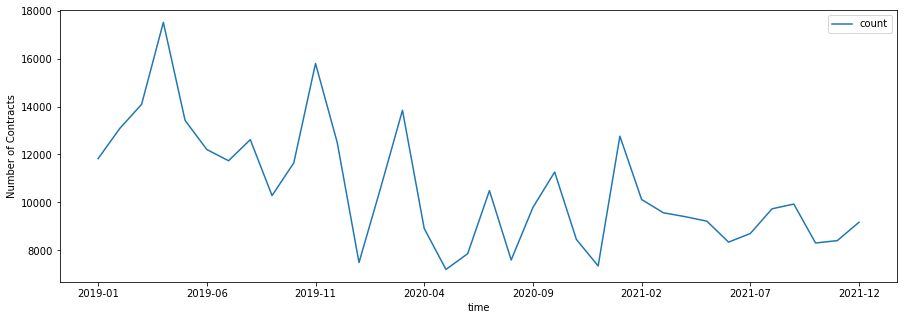

In [ ]:
f, ax1 = plt.subplots(1,1,figsize=(15,5))
balanced_covid1.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")

In [ ]:
# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

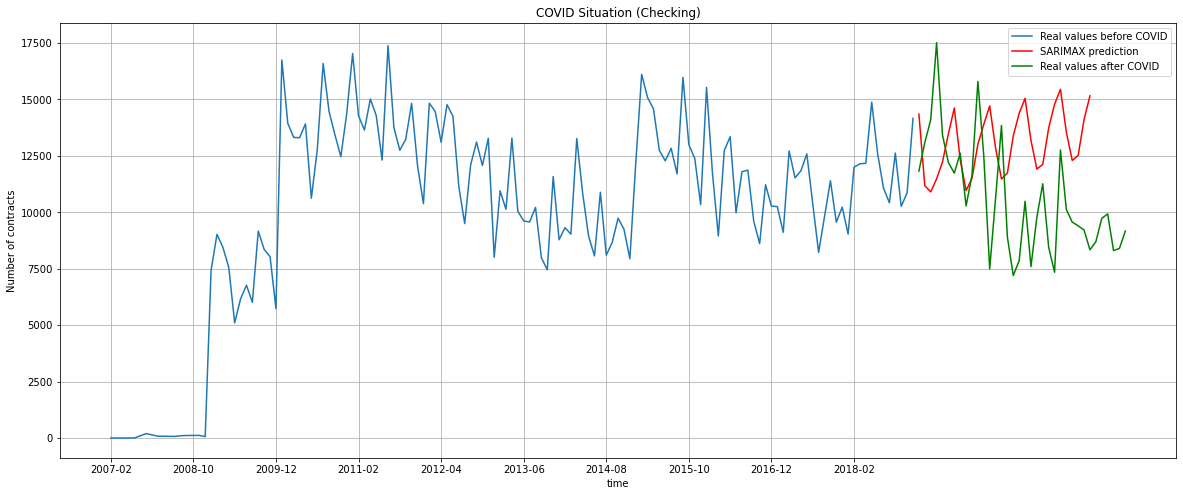

In [ ]:
# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,8))
plt.plot(balanced2, label='Real values before COVID')
plt.plot(forecast.predicted_mean, label='SARIMAX prediction', c="r")
plt.plot(balanced_covid1, label='Real values after COVID', c='g')
plt.xticks(balanced2.index.unique())

plt.locator_params(axis='x', nbins=10)
plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.title('COVID Situation (Checking)')
plt.legend()
plt.grid(True)
plt.show()

# Results